In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.preprocessing import MinMaxScaler

# Data Preprocessing

## Dataset creation

In [38]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [39]:
biomass_by_week_year_group

week  year  month  group_num  Depth  sum_biomass_ug_ml
0        1  2018      1          2      3           0.039771
1        1  2018      1          2      5           0.211959
2        1  2018      1          2     10           0.035015
3        1  2018      1          2     15           0.073128
4        1  2018      1          2     20           0.100380
...    ...   ...    ...        ...    ...                ...
4704    52  2018     12          9      3           0.009807
4705    52  2018     12          9      5           0.009807
4706    52  2018     12          9     10           0.021500
4707    52  2018     12          9     15           0.018483
4708    52  2018     12          9     20           0.011316

[4709 rows x 6 columns]

In [40]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


## Splitting to test temporarily & Extracting probe's test data

In [41]:
merged_df = merge_fp_biomass_df(fp_df, biomass_by_week_year_group)

In [42]:
merged_df_test = merged_df[(merged_df['year'] == 2022) & (merged_df['month'] >= 4)]
merged_df = merged_df[~merged_df.index.isin(merged_df_test.index)]

orig_merged_df = merged_df.copy()

merged_df = merged_df.drop(['week'], axis=1)
merged_df_test = merged_df_test.drop(['week'], axis=1)

In [43]:
merged_df = merged_df.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_test_df = merged_df_test[['group_num', 'month', 'Depth', 'pressure', 'temp_sensor', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta', 'Total conc']].reset_index(drop=True)
merged_df_test = merged_df_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

# Plot

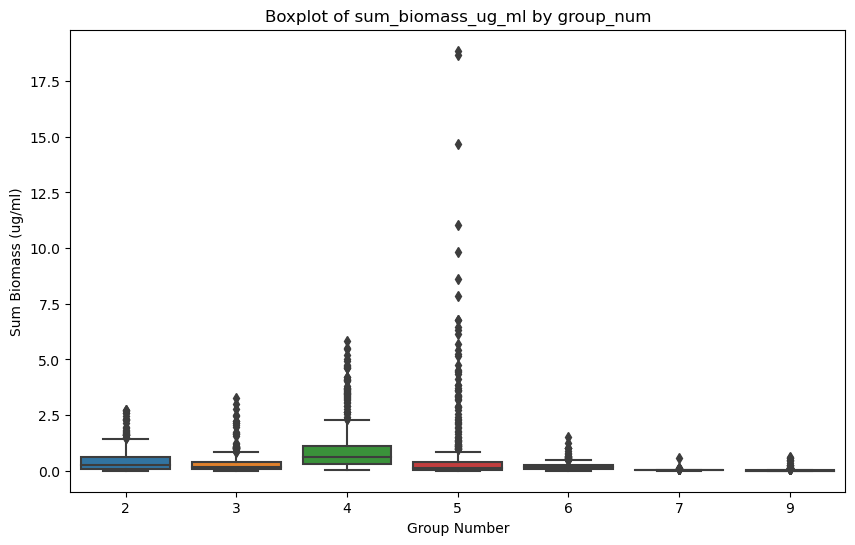

In [44]:
boxplot(merged_df)

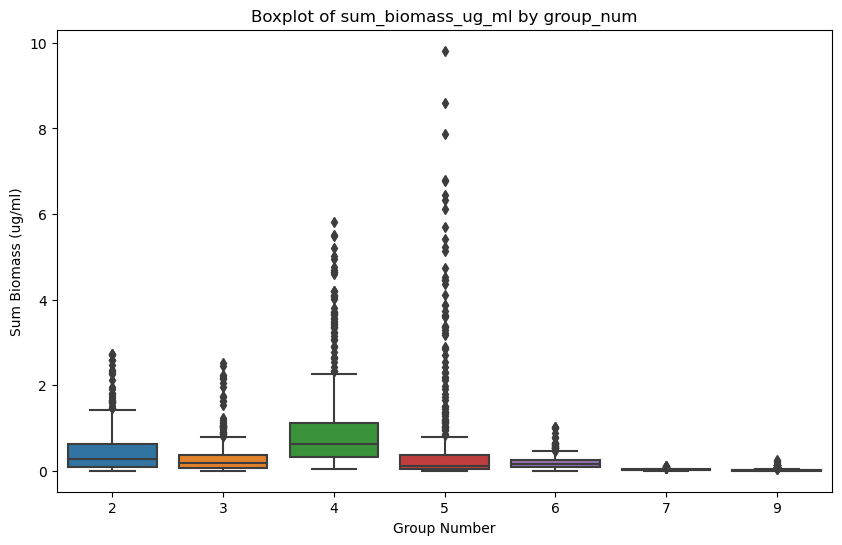

In [45]:
filtered_df = remove_outliers_IQR(merged_df, q1=0.05, q3=0.95)
merged_df = filtered_df
boxplot(filtered_df)

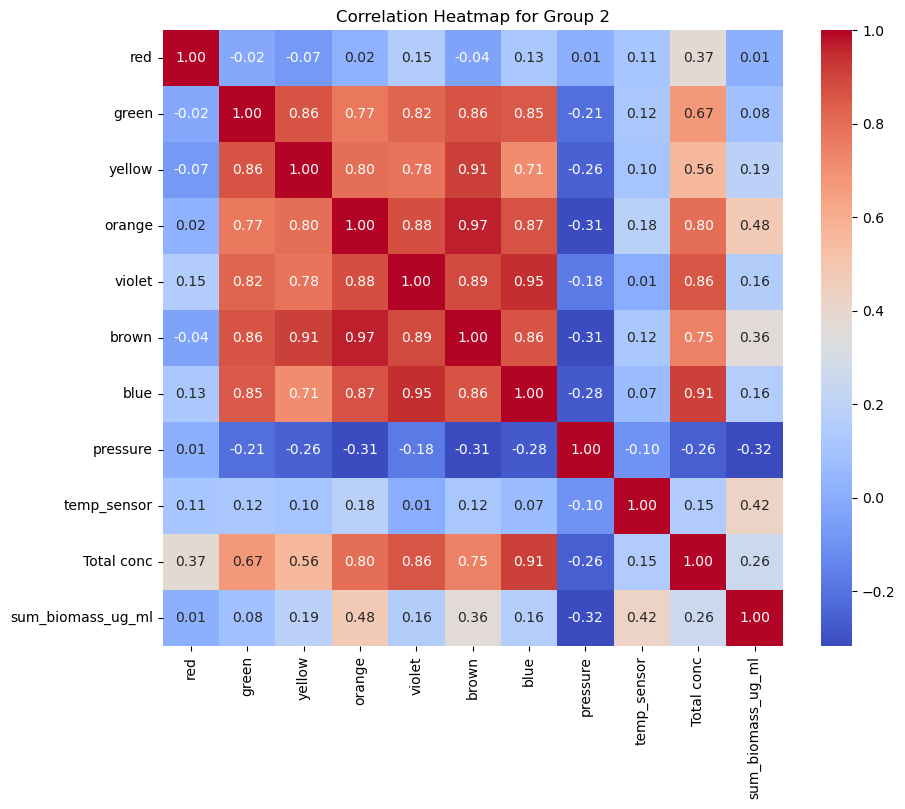

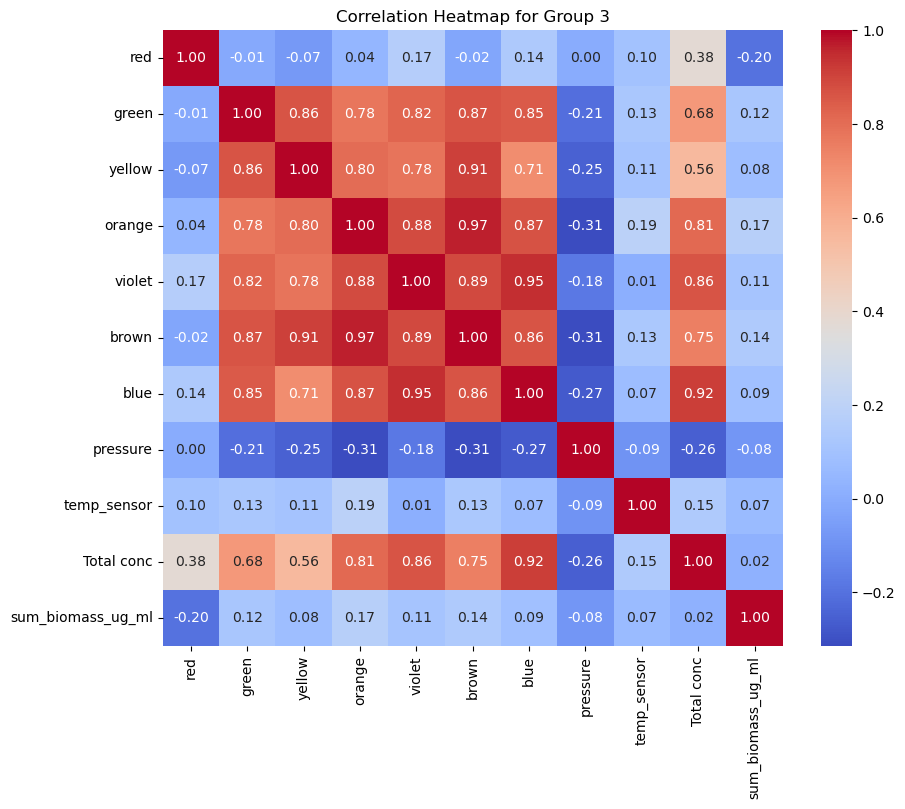

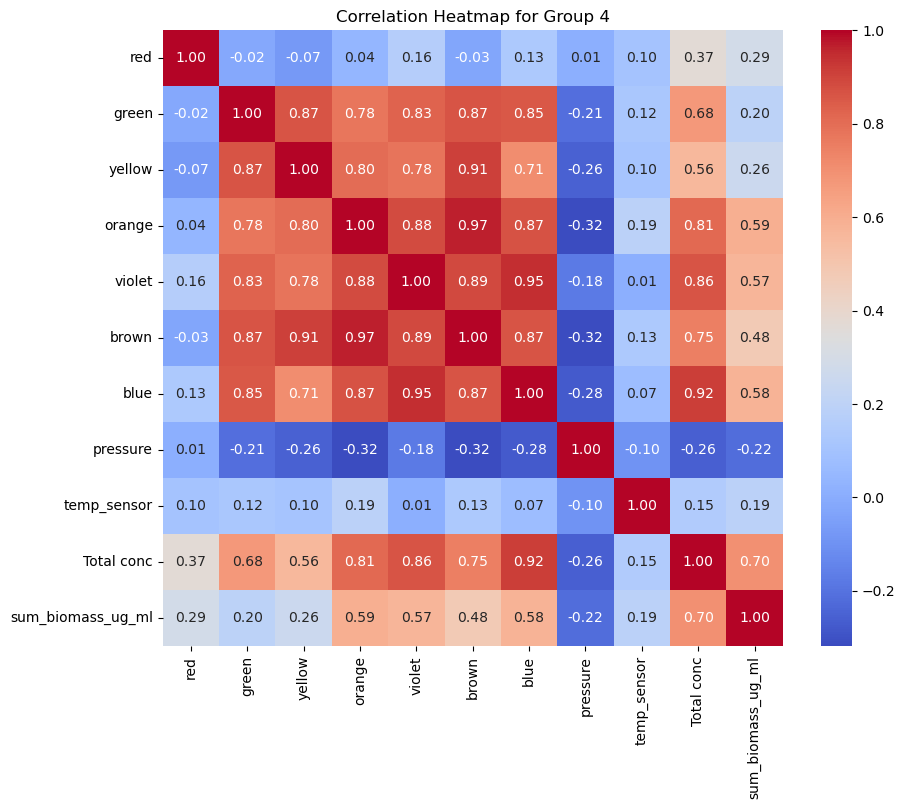

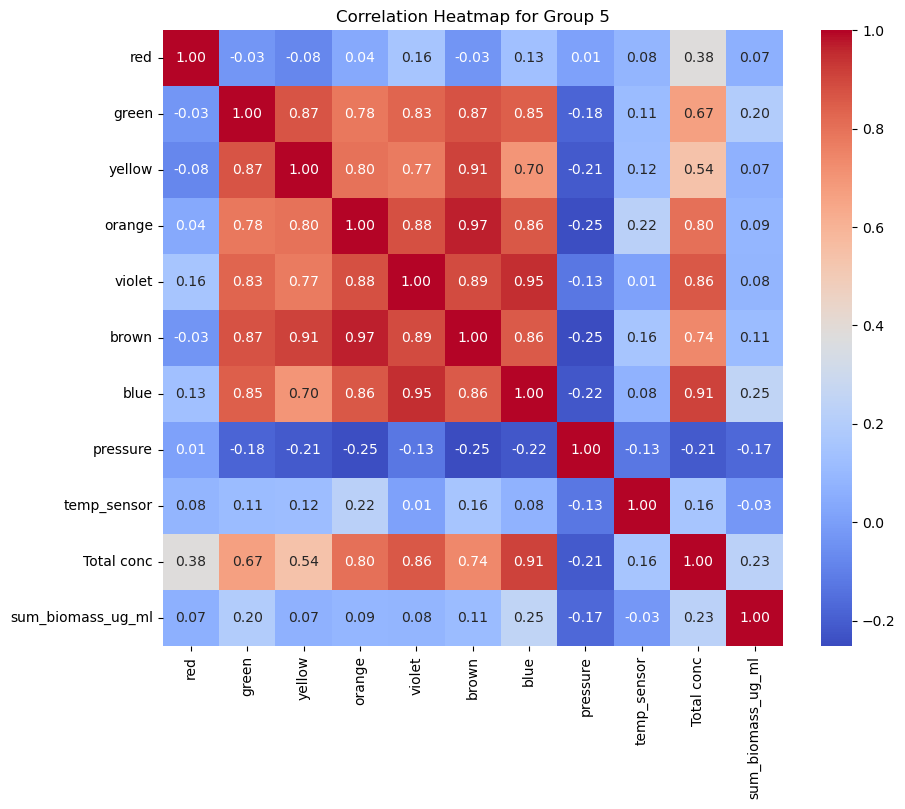

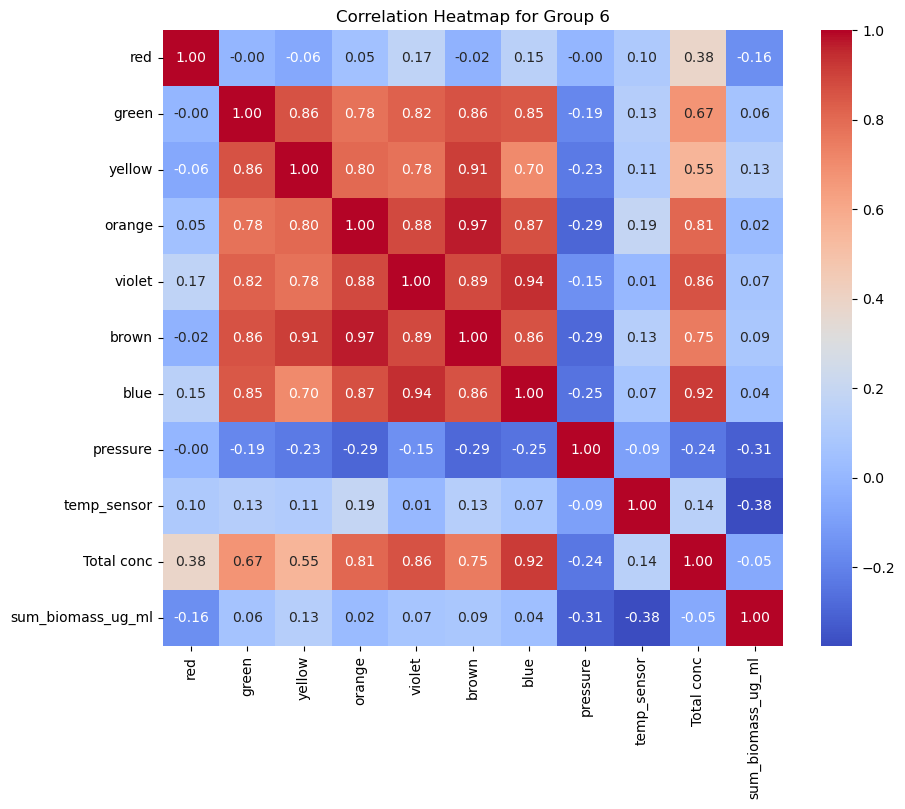

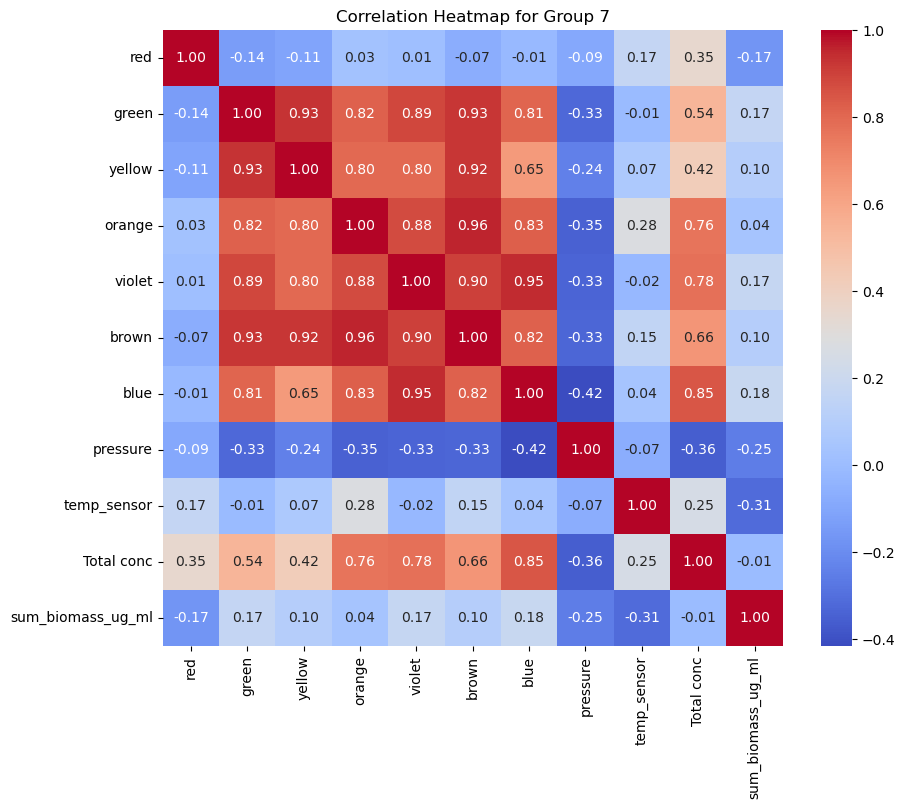

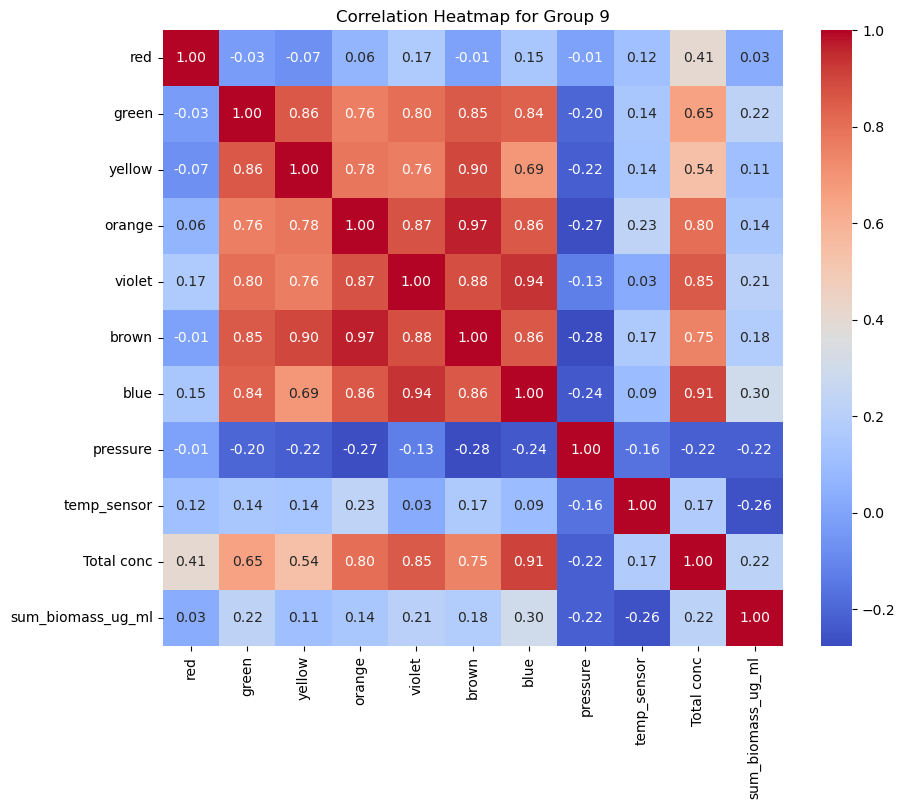

In [46]:
correlation_per_group(merged_df)

In [47]:
# keep_cols = ['red', 'green', 'orange', 'pressure', 'temp_sensor', 'Total conc', 'sum_biomass_ug_ml', 'group_num']

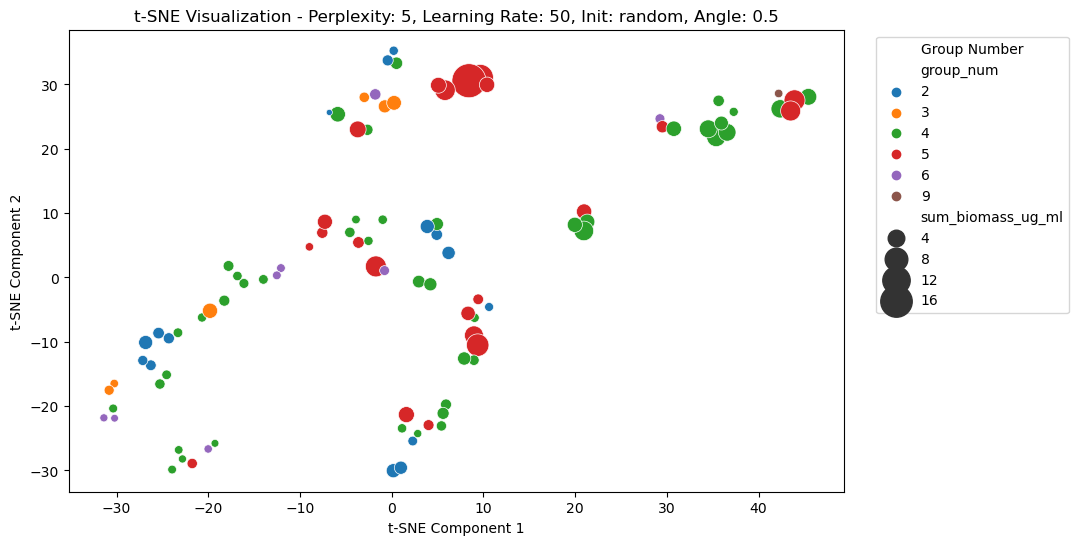

In [48]:
plot_tsne(orig_merged_df)

In [68]:
group_order = [5, 4, 2, 3, 6, 9, 7]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


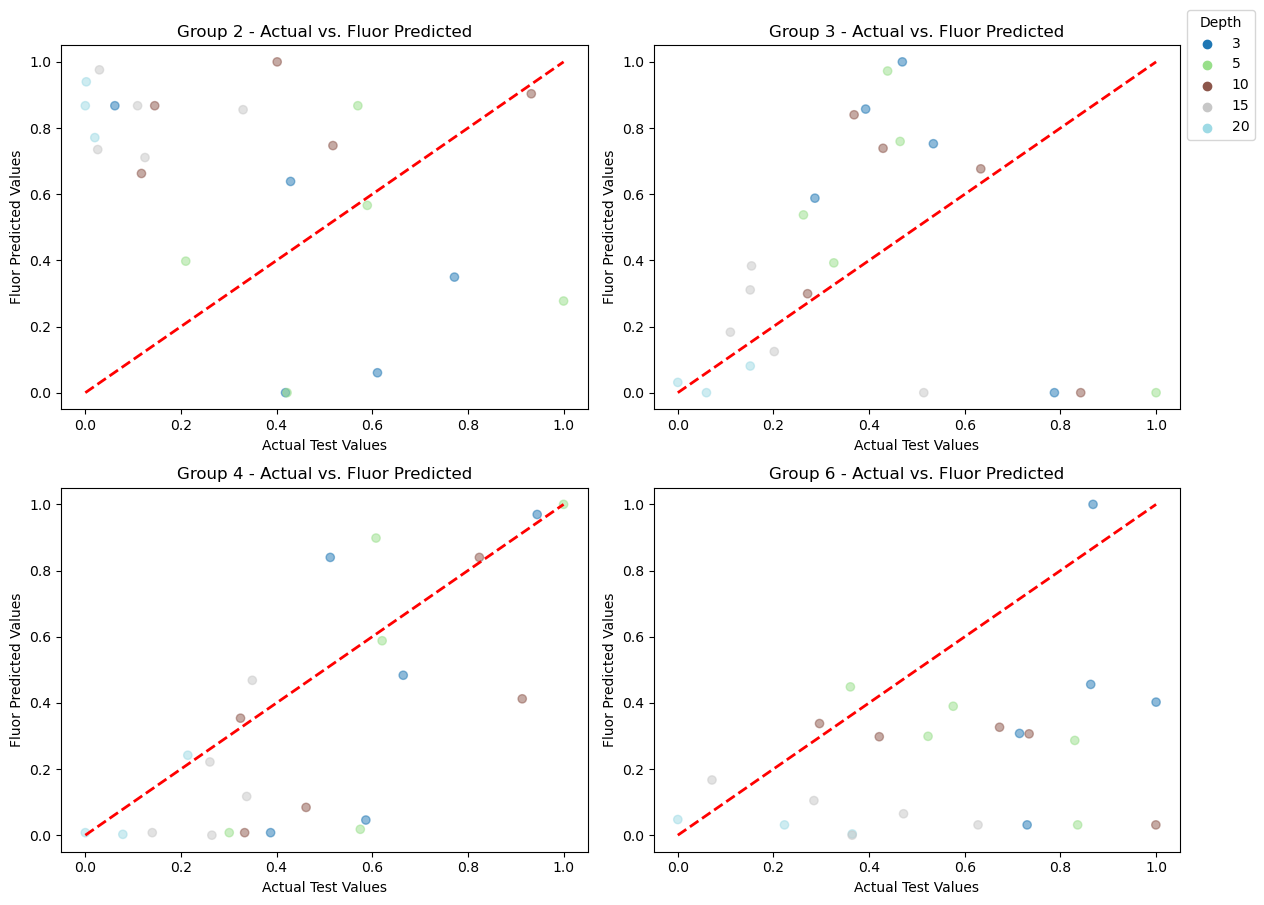

In [49]:
plot_fluorprobe_prediction(fluor_test_df, fluor_groups_map)

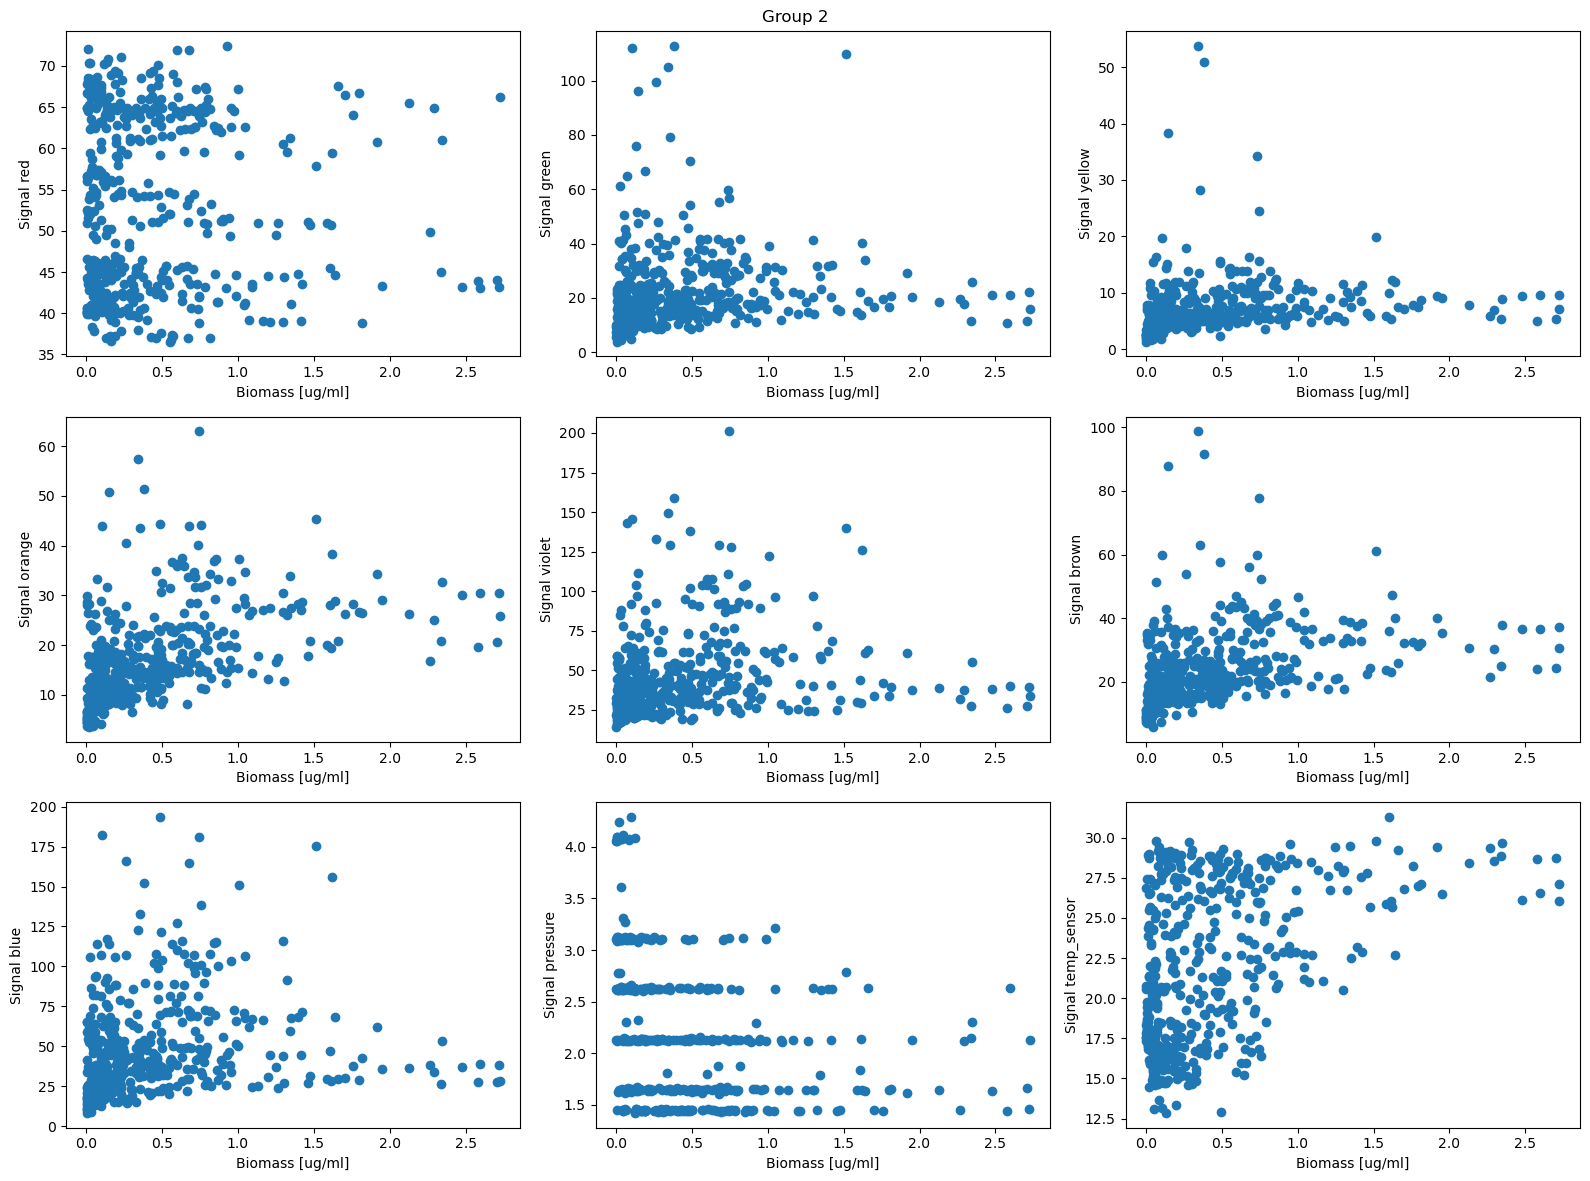

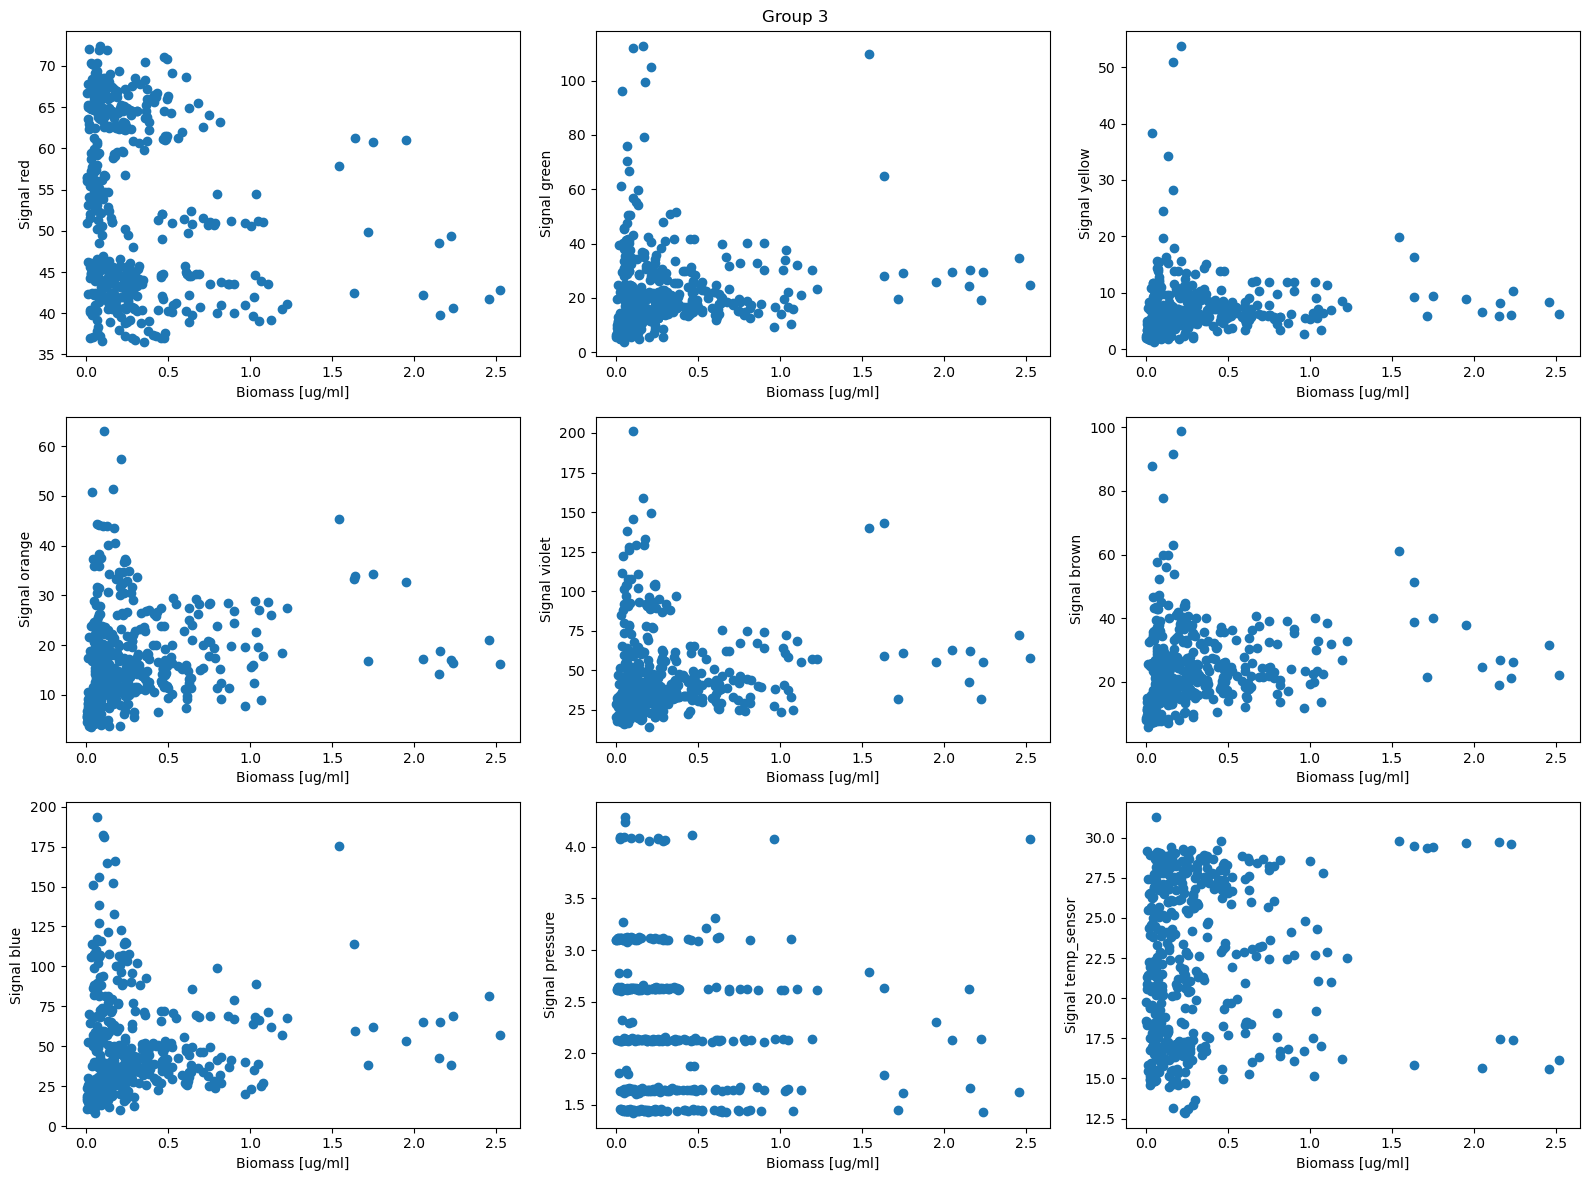

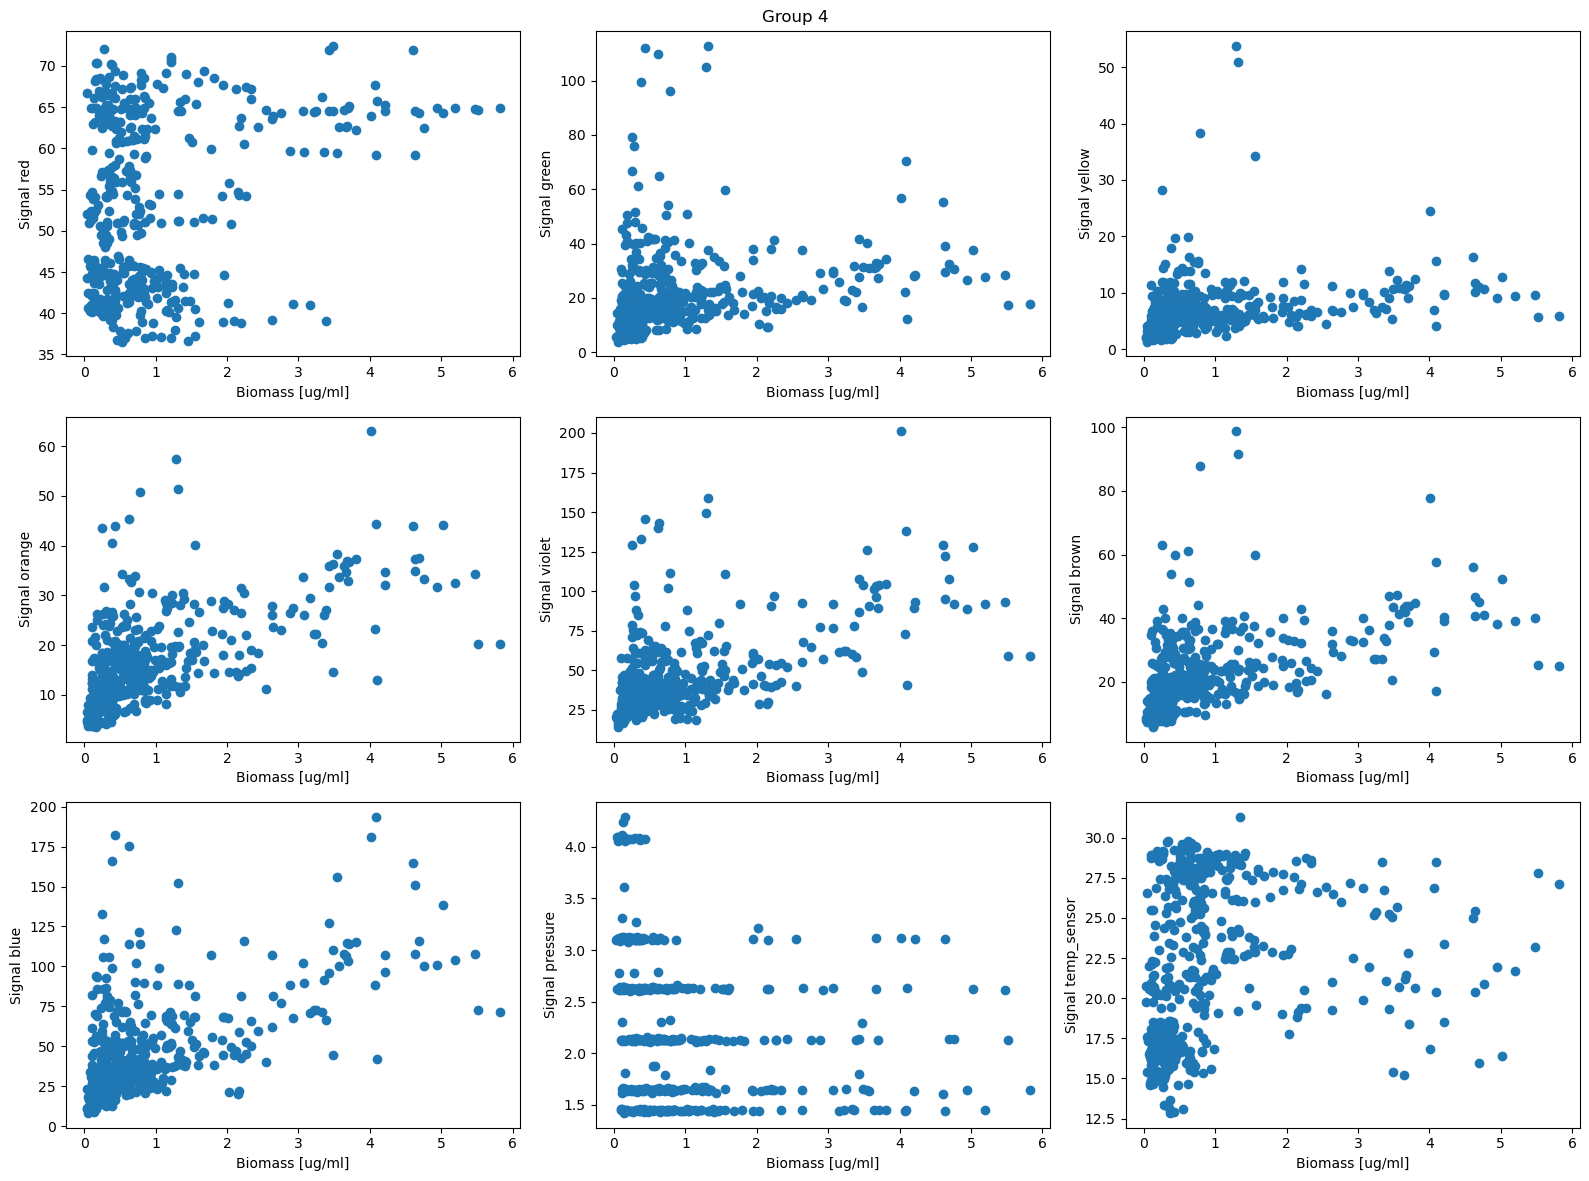

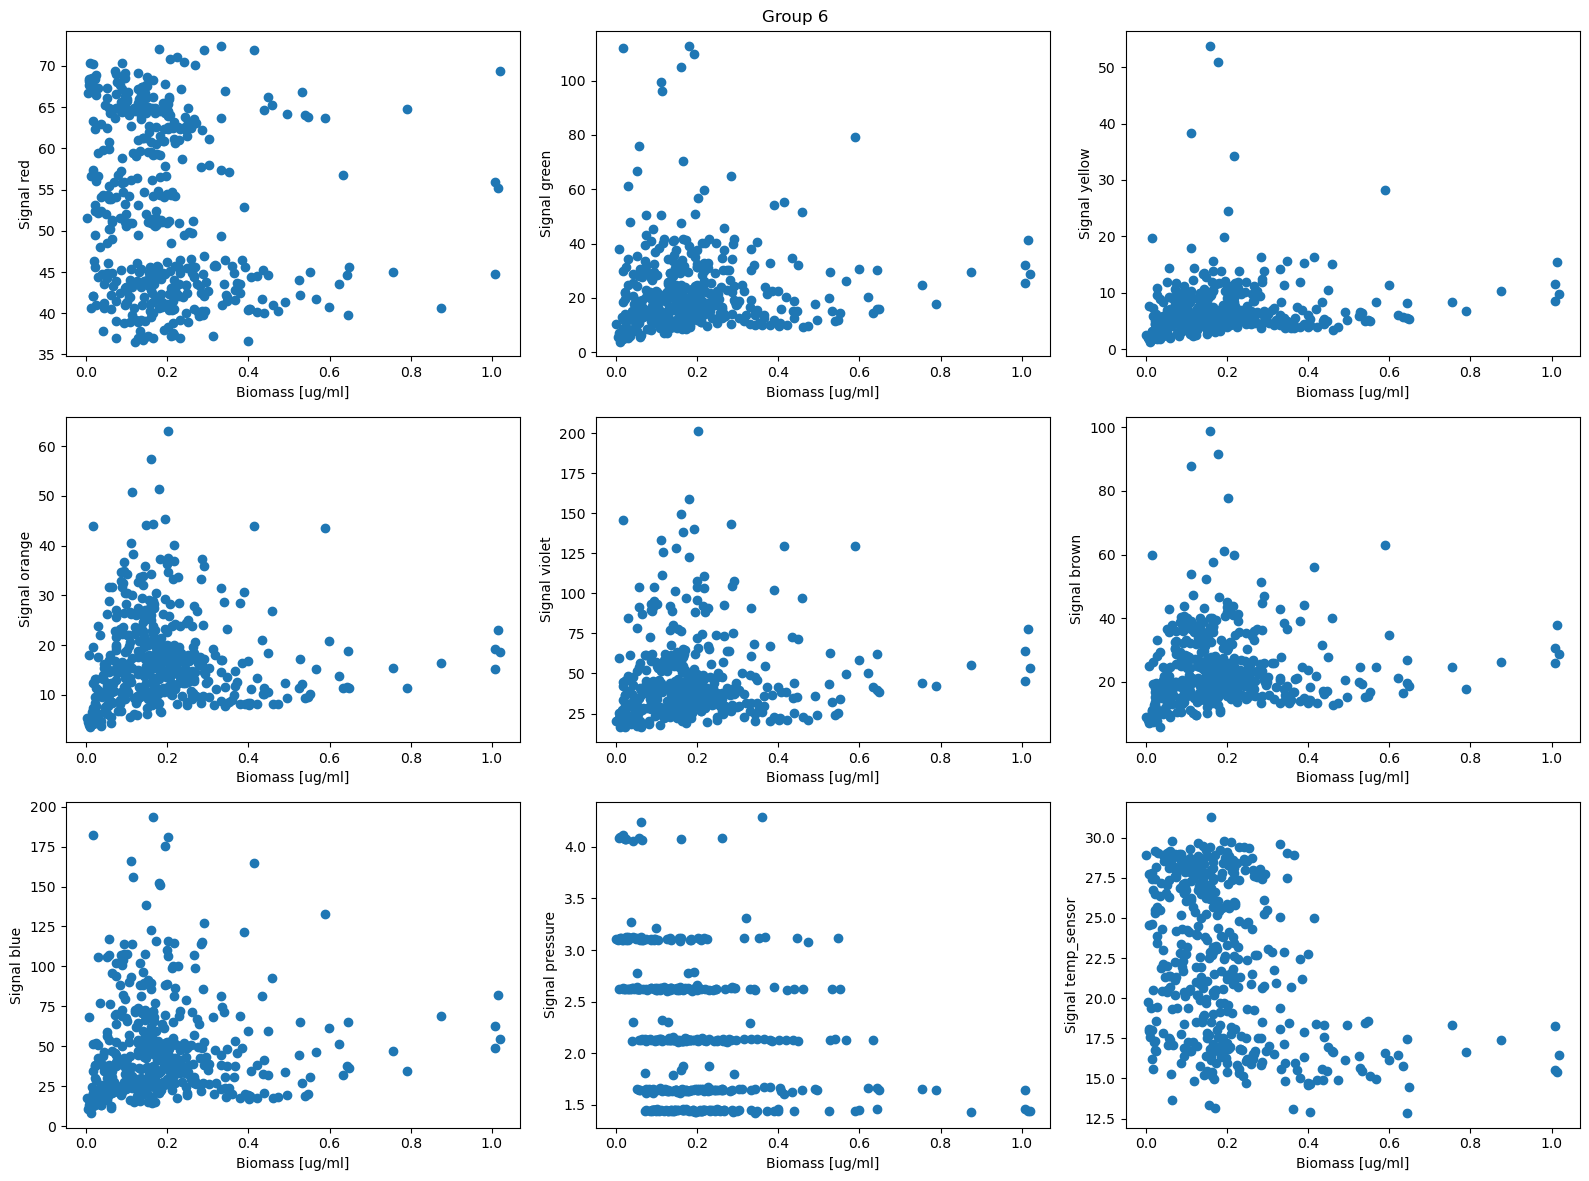

In [50]:
plot_corr_per_feature_per_group(merged_df, fluor_groups_map)

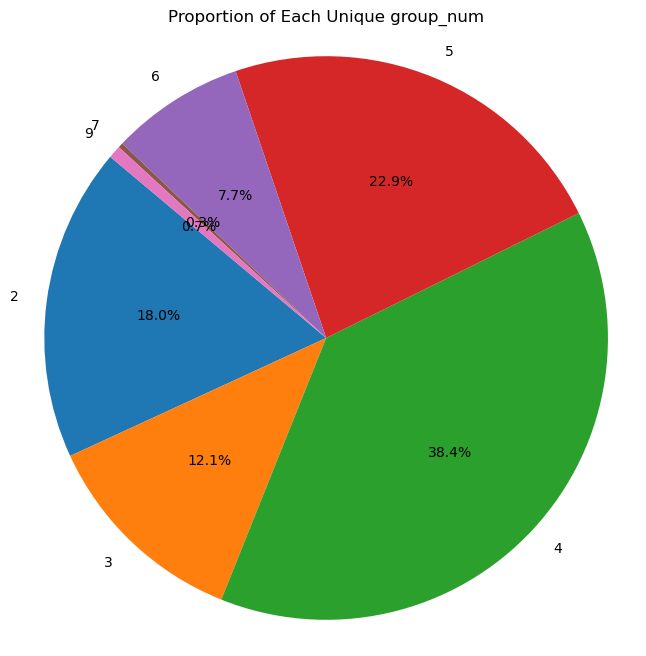

In [51]:
groups_pie_chart(merged_df, by_biomass=True)

In [52]:
merged_df = merged_df.drop(['year', 'Depth'], axis=1)
merged_df_test = merged_df_test.drop(['year', 'Depth'], axis=1)
fluor_test_df = fluor_test_df.drop('Depth', axis=1)

# Training models and evaluating

## Linear Regression

In [54]:
regression_models_lr, preds_real_y_lr = train('lr', merged_df, test_size=0.2)

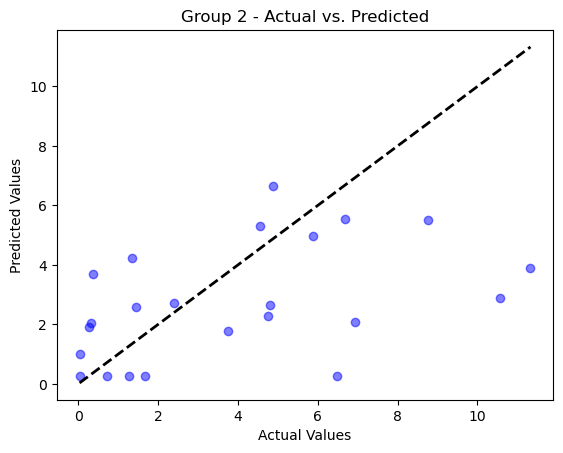

Results for group_num 2:
MSE: 10.326236904547839
R-squared: 0.08108280949925895



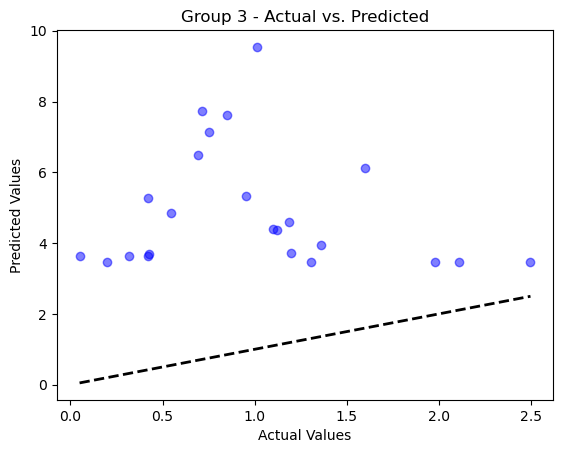

Results for group_num 3:
MSE: 18.93736421097314
R-squared: -49.62858588398811



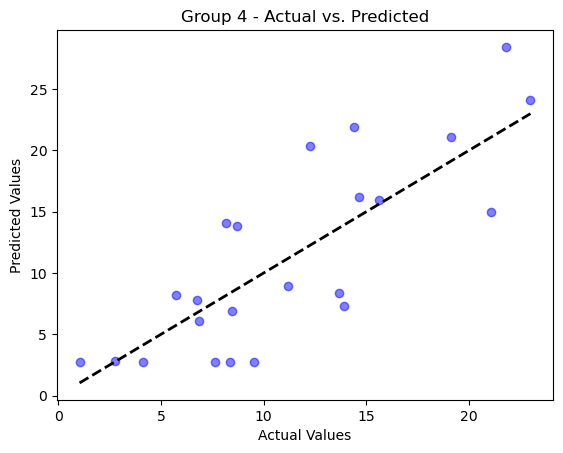

Results for group_num 4:
MSE: 20.263009056894077
R-squared: 0.4229933159242981



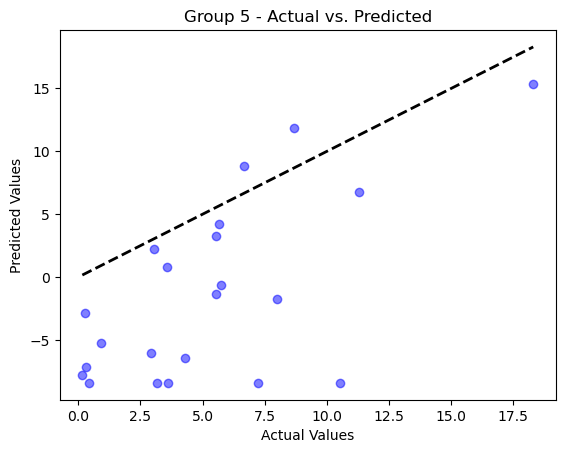

Results for group_num 5:
MSE: 71.29268112096135
R-squared: -2.936332232705216



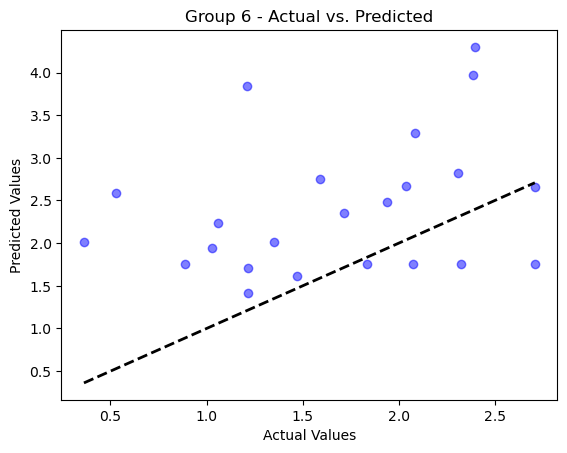

Results for group_num 6:
MSE: 1.274916778384123
R-squared: -1.9938813843960173



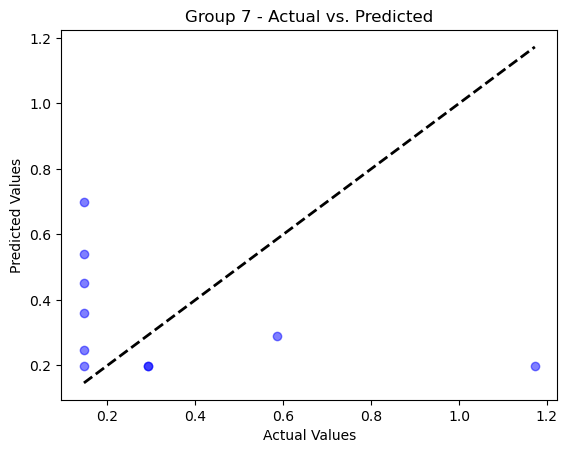

Results for group_num 7:
MSE: 0.1667257462398016
R-squared: -0.7020110933514279



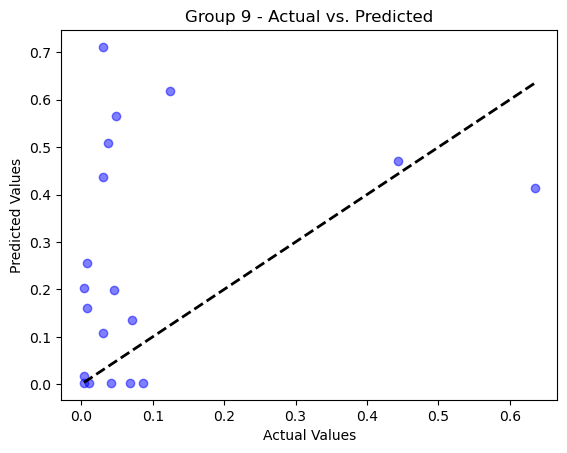

Results for group_num 9:
MSE: 0.0833894575940438
R-squared: -2.2612195455949453

Total MSE: 17.477760467942055, Total R-squared: -8.145422002087454


In [55]:
eval_test(regression_models_lr, merged_df_test)

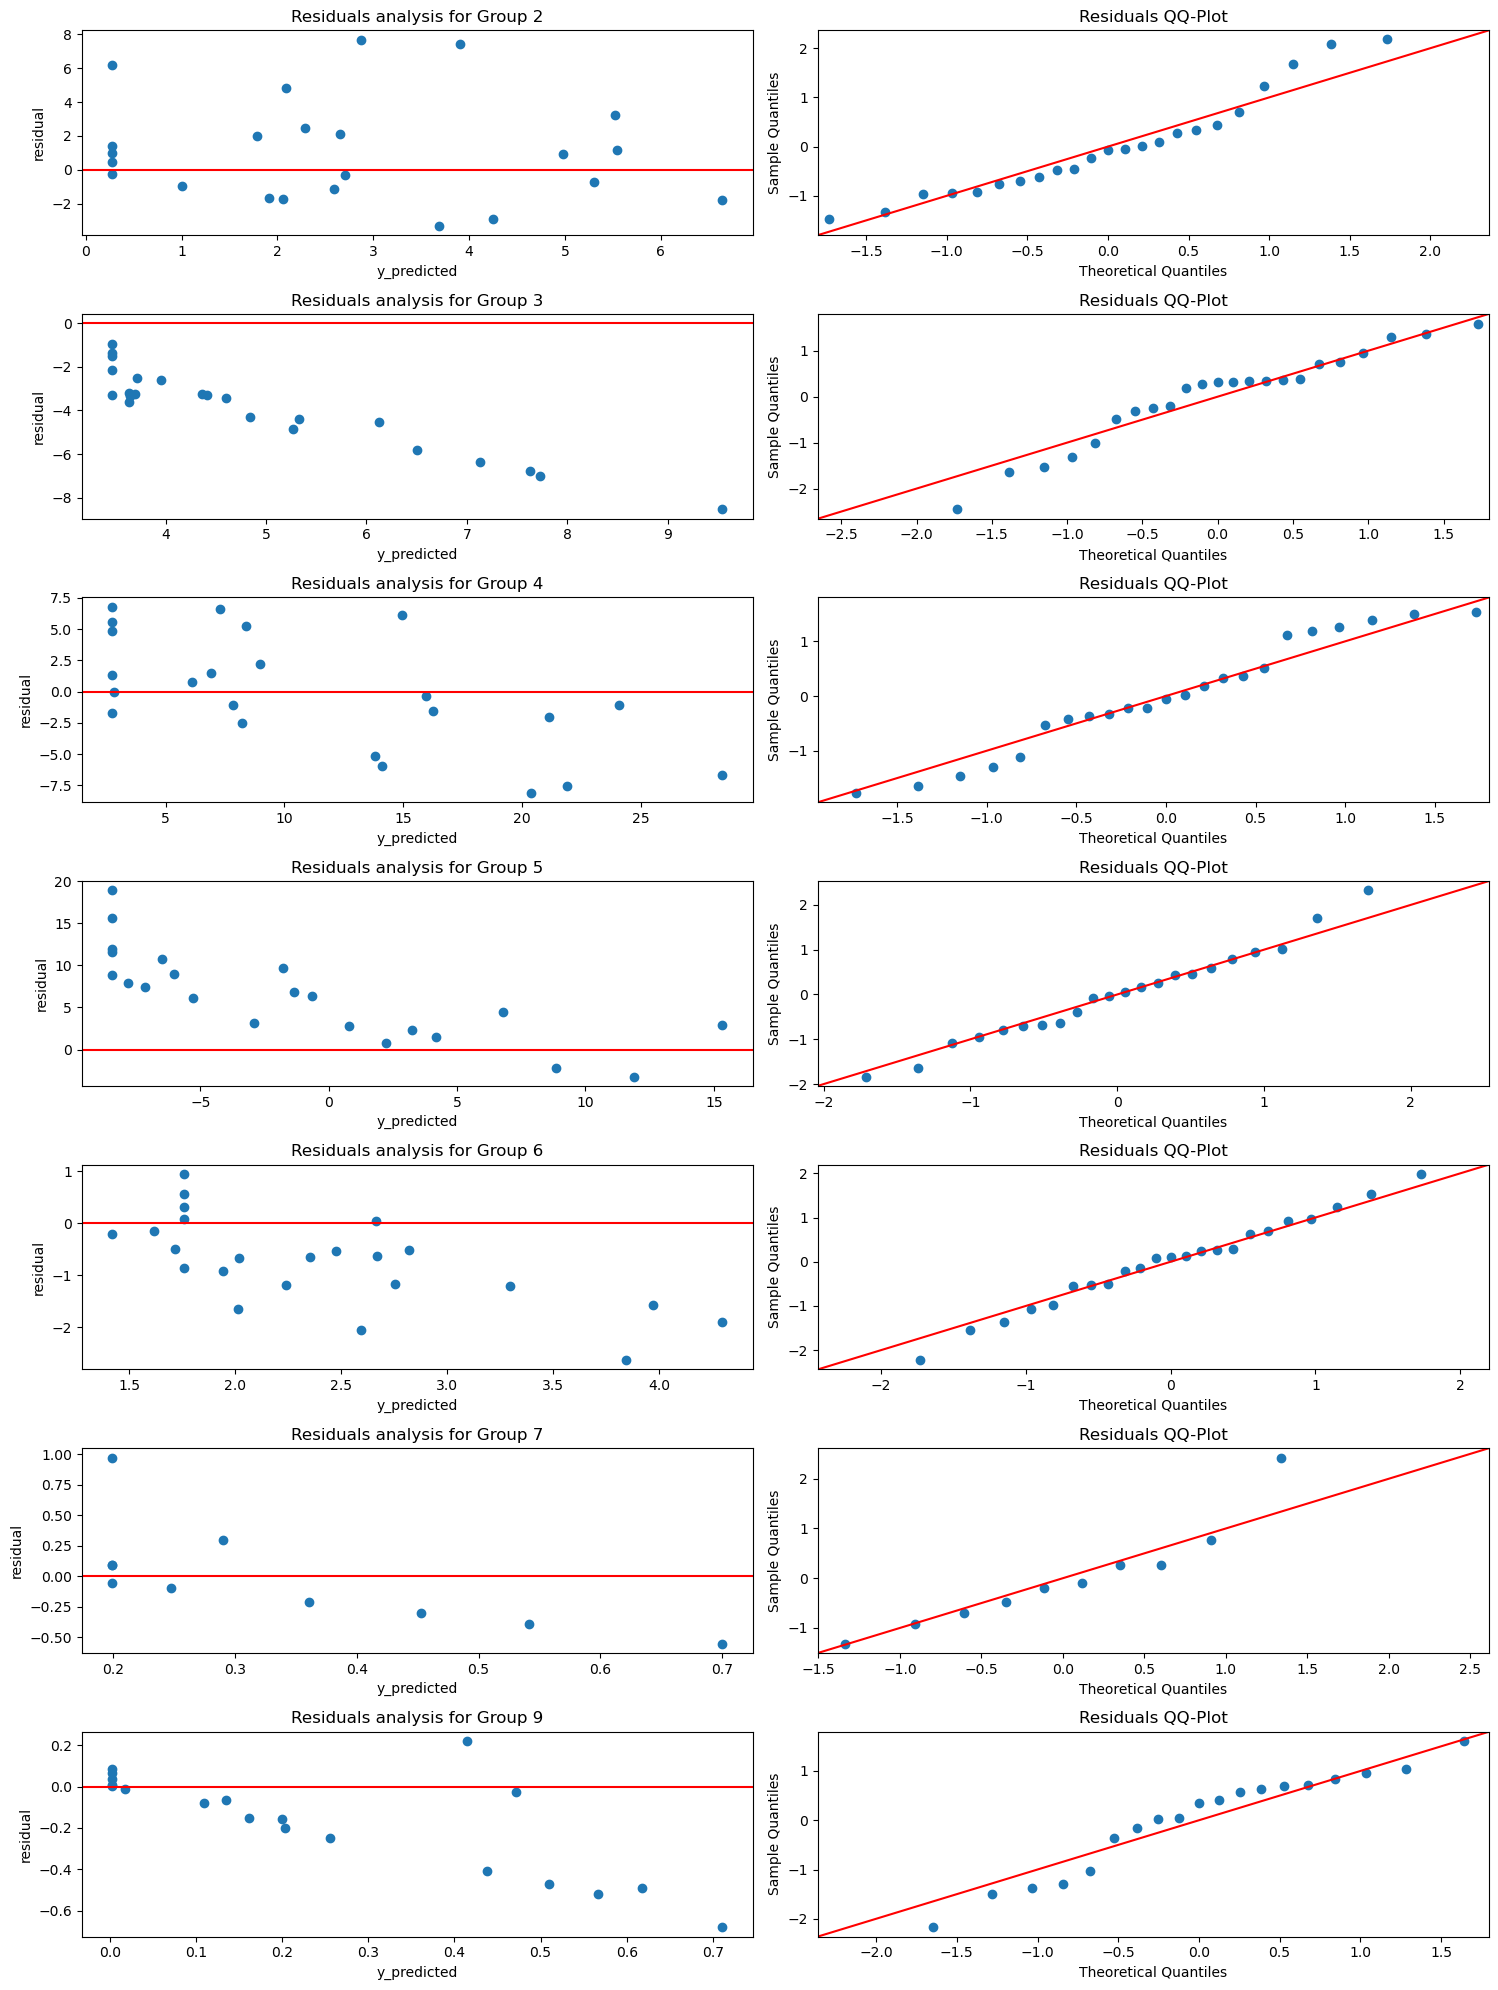

In [56]:
residual_analysis(merged_df_test, regression_models_lr)

## XGBoost

In [57]:
# keep_cols = merged_df.columns

In [58]:
# from sklearn.feature_selection import SelectKBest, f_regression
# selkbest= SelectKBest(f_regression, k=5)
# X_new = selkbest.fit_transform(merged_df.drop('sum_biomass_ug_ml', axis=1), merged_df['sum_biomass_ug_ml'])

In [59]:
# selkbest.get_feature_names_out()

In [60]:
# keep_cols = ['orange', 'brown', 'blue', 'Total conc', 'group_num', 'sum_biomass_ug_ml']

In [61]:
regression_models_xgboost, preds_real_y_xgboost = train('xgb', merged_df, test_size=0.0, biomass_factor=100)

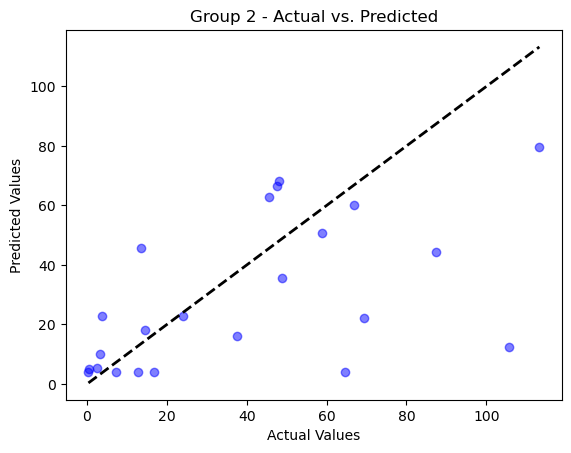

Results for group_num 2:
MSE: 917.5027397169982
R-squared: 0.18352731236859587



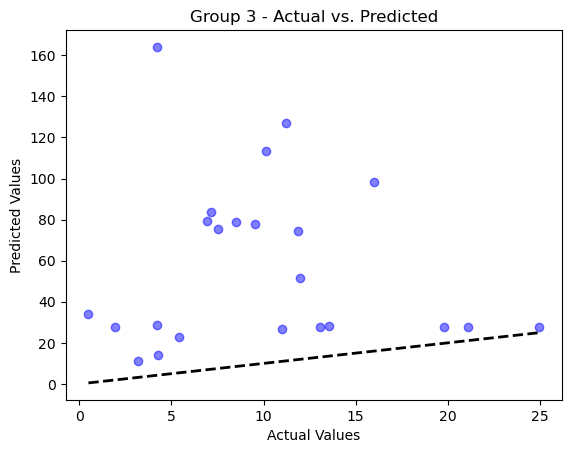

Results for group_num 3:
MSE: 3953.1736818640625
R-squared: -104.68714370007426



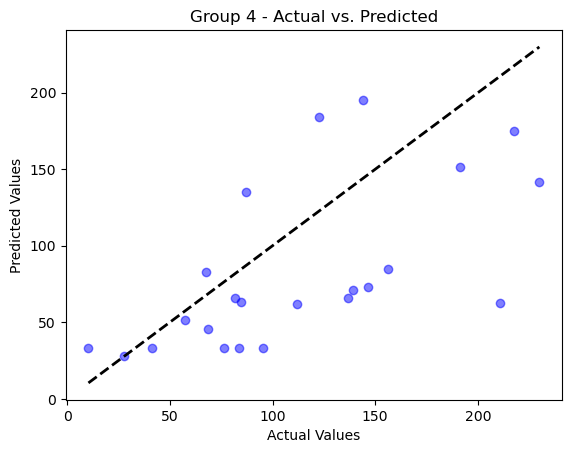

Results for group_num 4:
MSE: 3261.999763266355
R-squared: 0.0711173934862035



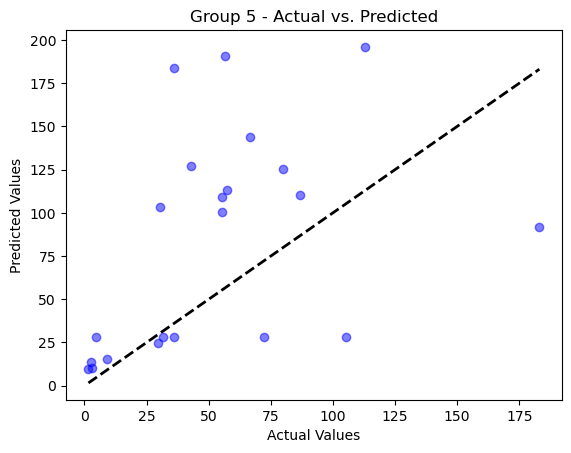

Results for group_num 5:
MSE: 4233.4770464118565
R-squared: -1.3374590339693424



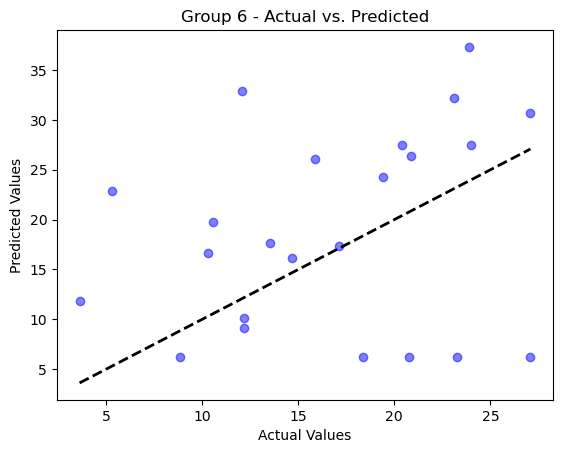

Results for group_num 6:
MSE: 110.87549495702994
R-squared: -1.6036843028944197



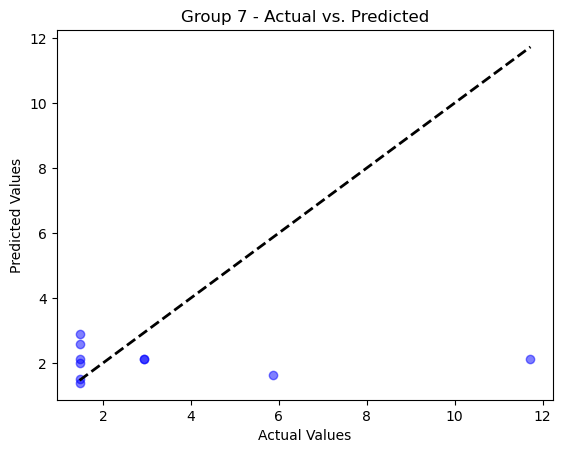

Results for group_num 7:
MSE: 11.57804205559342
R-squared: -0.1819383905810381



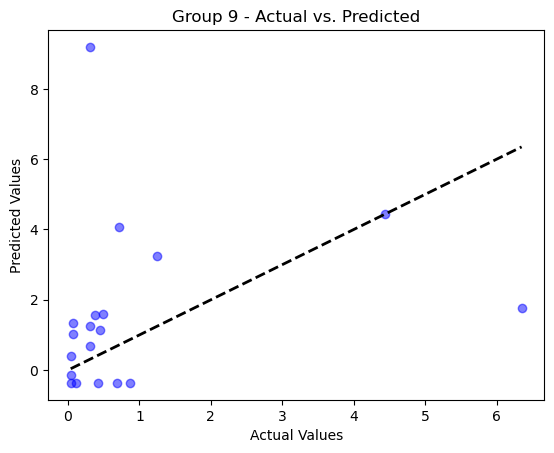

Results for group_num 9:
MSE: 6.616366093509795
R-squared: -1.5875480003730127

Total MSE: 1785.0318763379148, Total R-squared: -15.59187553171961


In [62]:
eval_test(regression_models_xgboost, merged_df_test, biomass_factor=100)

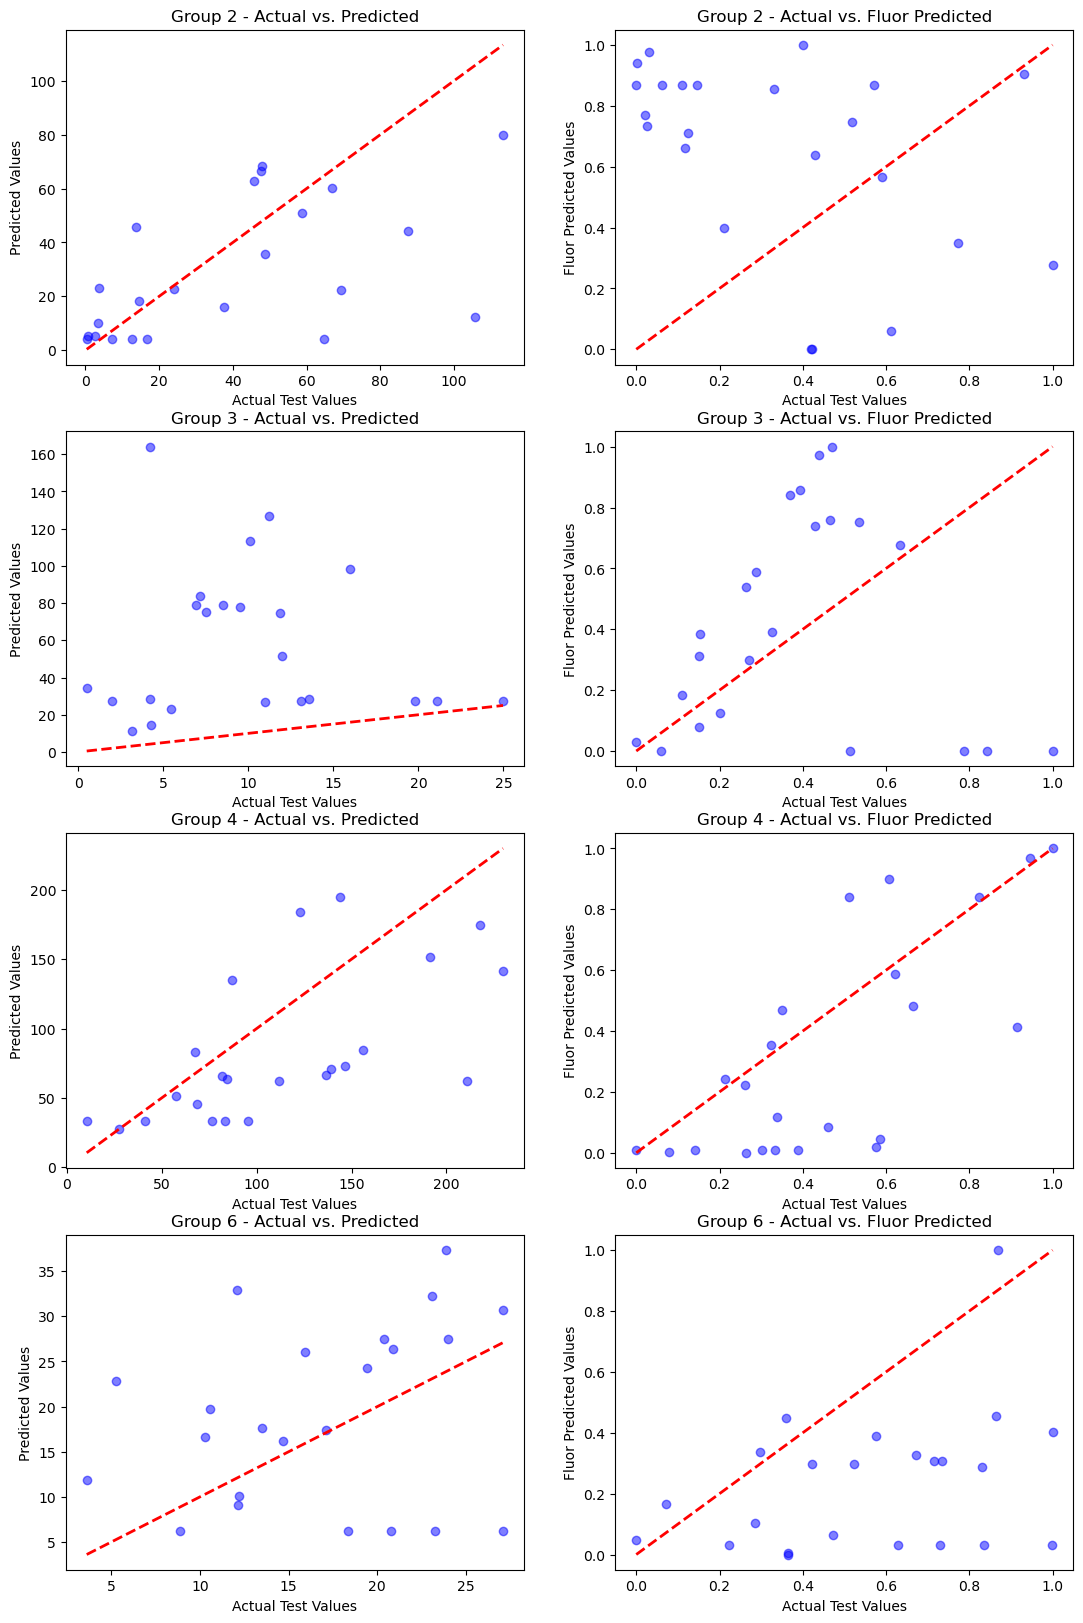

In [63]:
compare_to_fluor(regression_models_xgboost, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)

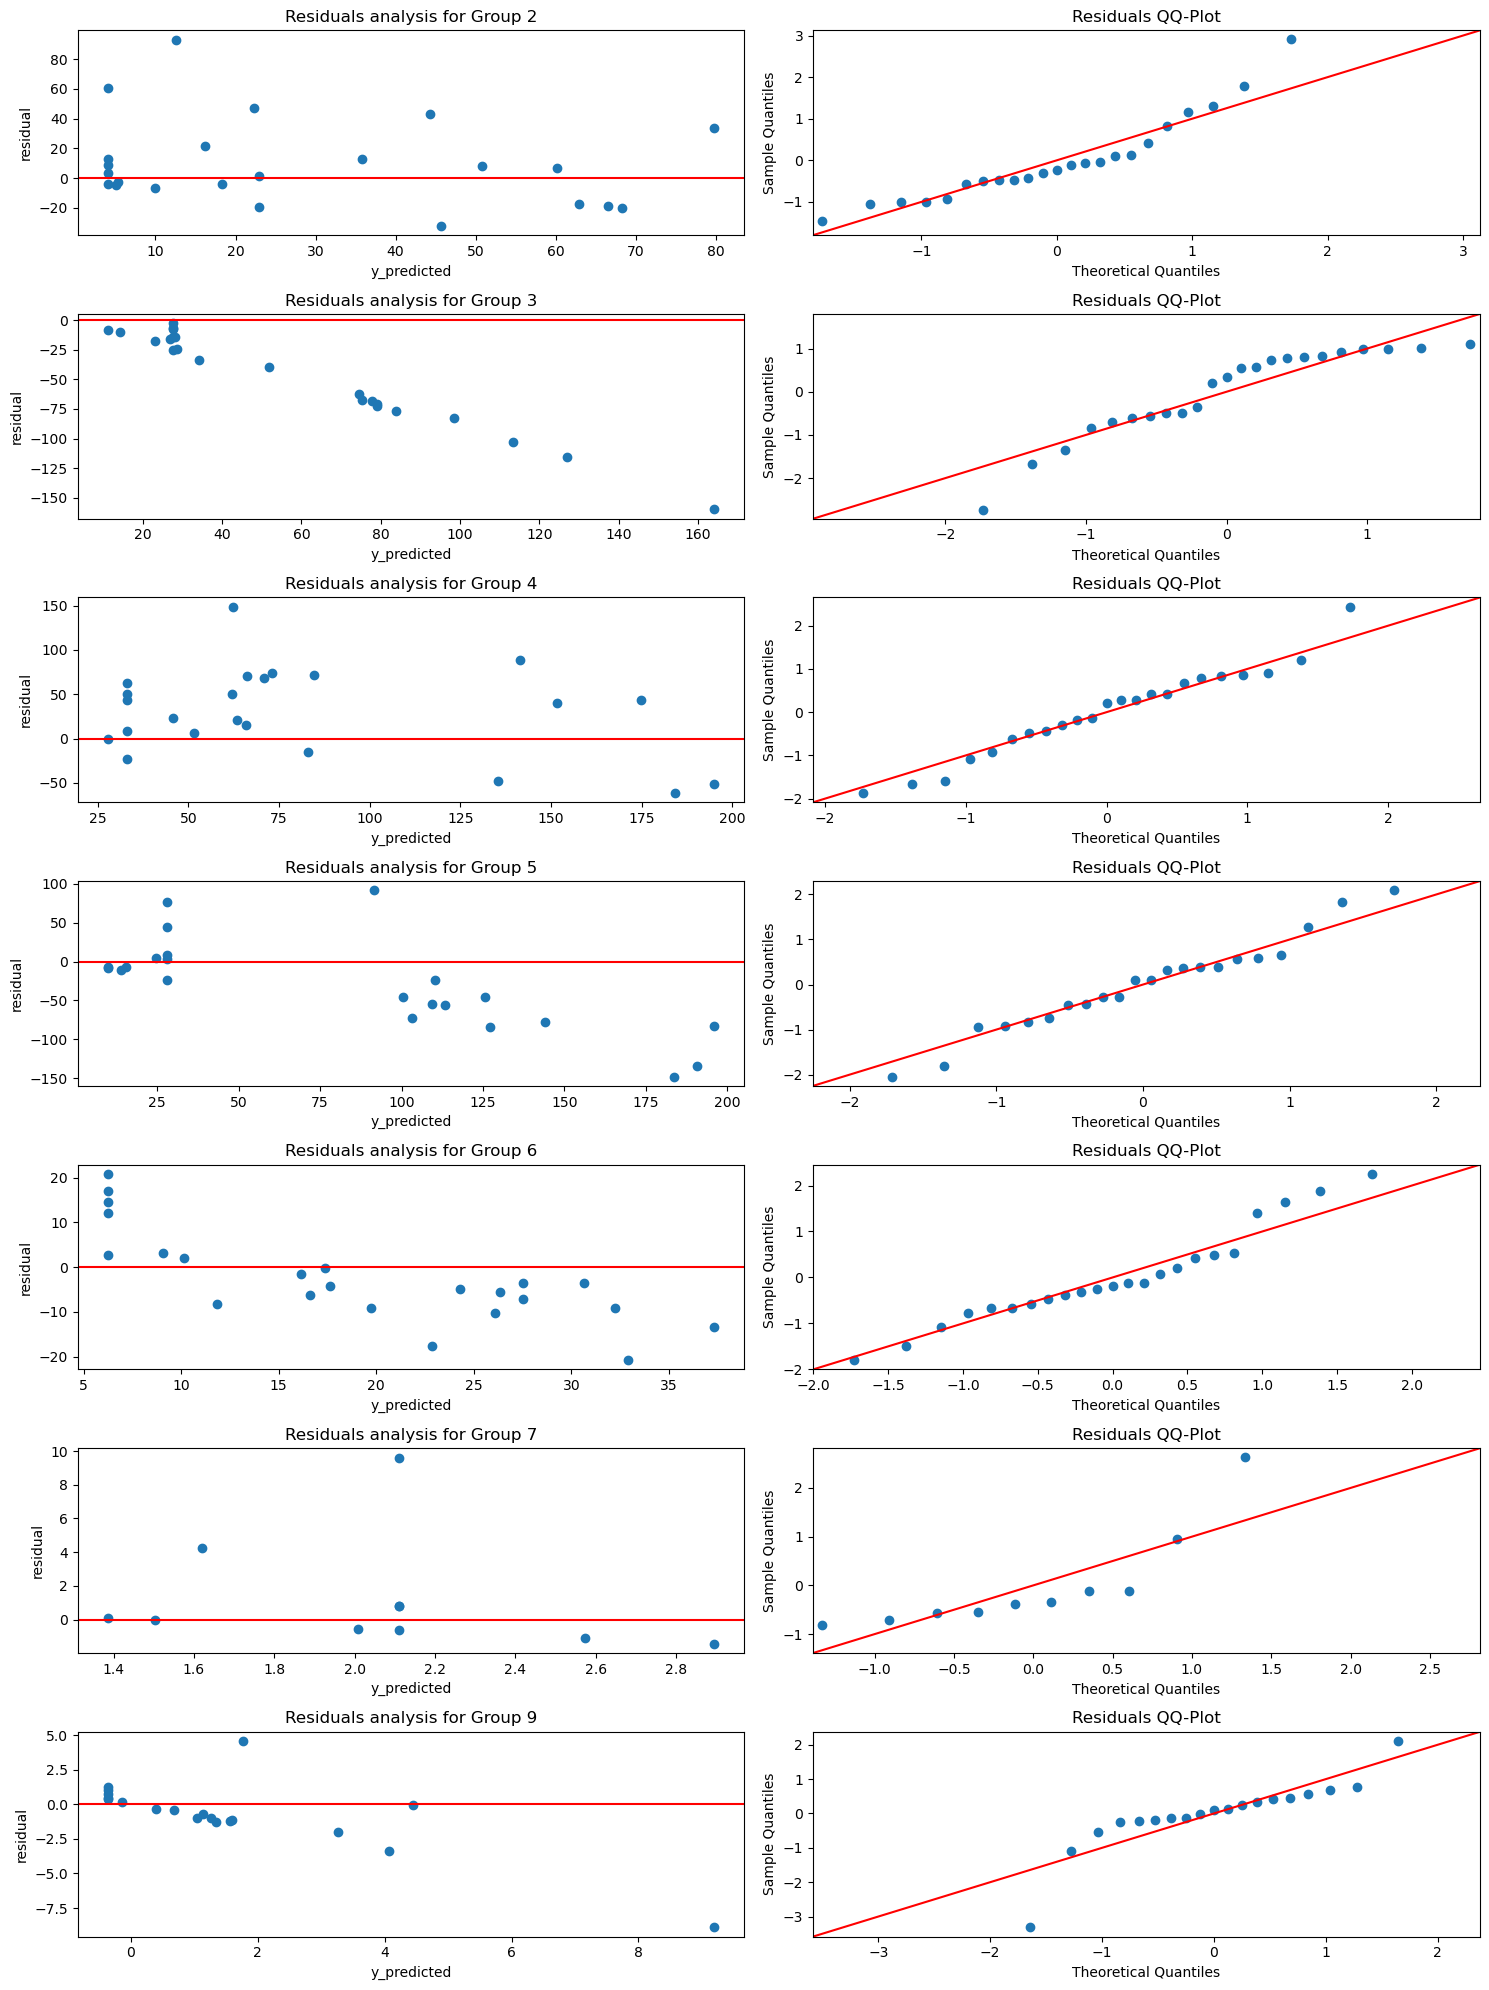

In [64]:
residual_analysis(merged_df_test, regression_models_xgboost, biomass_factor=100)

In [65]:
shap_values_list = plot_shap_values(merged_df_test, regression_models_xgboost, merged_df_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=100, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=None, ...),
                           transformer=StandardScaler())

In [ ]:
features_list = merged_df_test.drop(['group_num', 'sum_biomass_ug_ml'], axis=1).columns.tolist()

# Create a DataFrame from the Shapley values
shap_df = pd.DataFrame({k: np.average(v, axis=0) for k, v in shap_values_list.items()}, index=features_list)

scaler = MinMaxScaler()
scaled_shap_df = pd.DataFrame(scaler.fit_transform(shap_df), columns=shap_df.columns, index=shap_df.index)
    
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(scaled_shap_df.transpose(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Shapley Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Group Number")
plt.show()


### Train iteratively over previous predictions

In [69]:
regression_models_xgboost, preds_real_y_xgboost = train_iterative('xgb', merged_df, test_size=0.0, biomass_factor=100, group_order=group_order)

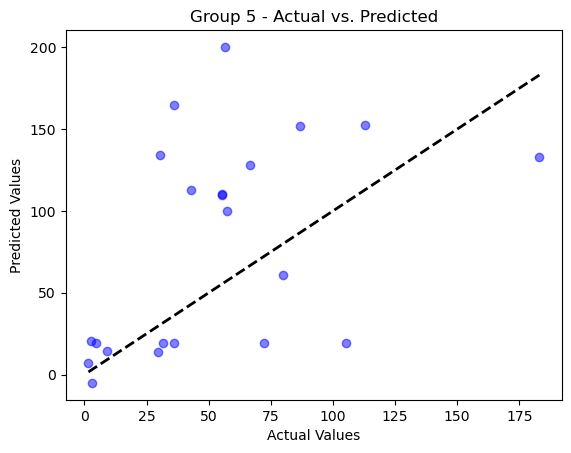

Results for group_num 5:
MSE: 3853.366976220322
R-squared: -1.1275862254643387



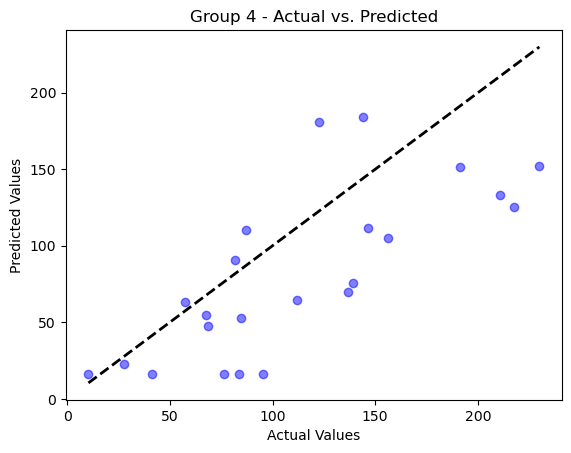

Results for group_num 4:
MSE: 2574.209880465225
R-squared: 0.2669715030617368



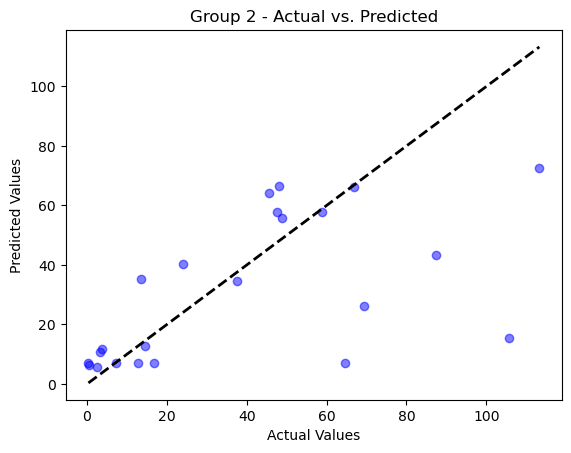

Results for group_num 2:
MSE: 821.4514197815458
R-squared: 0.2690020209917354



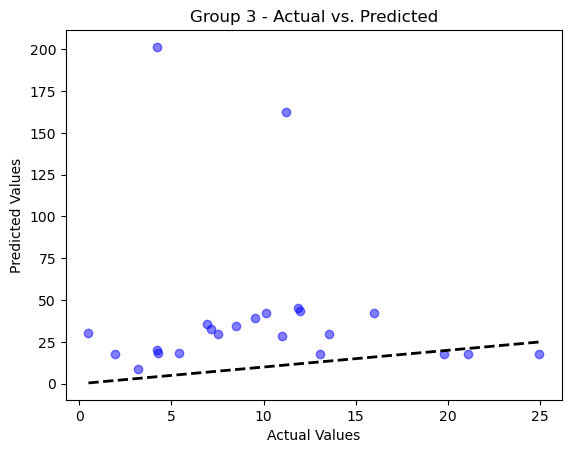

Results for group_num 3:
MSE: 3113.06964556879
R-squared: -82.22716517338223



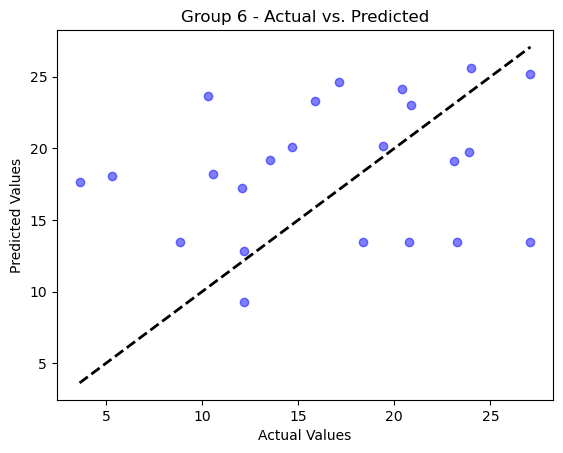

Results for group_num 6:
MSE: 53.992714766087936
R-squared: -0.26790851271149685



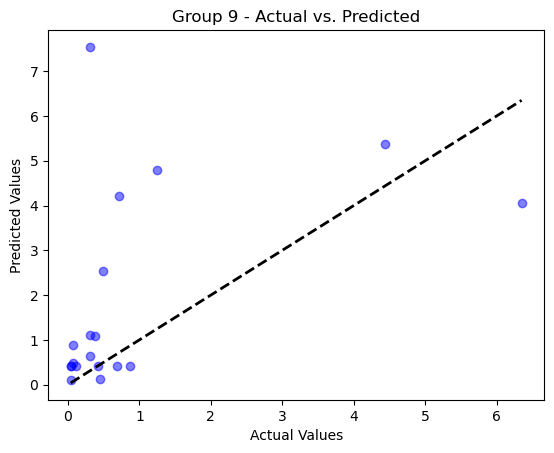

Results for group_num 9:
MSE: 4.7663568883637275
R-squared: -0.8640409344409925



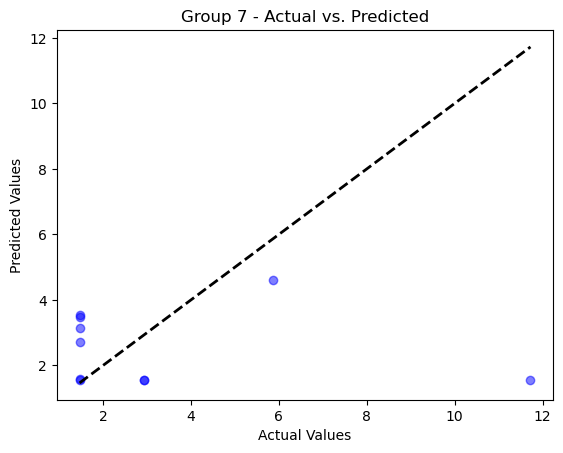

Results for group_num 7:
MSE: 12.18982580961909
R-squared: -0.24439201634476526

Total MSE: 1490.4352599285648, Total R-squared: -12.027874191184337


In [70]:
eval_test_iterative(regression_models_xgboost, merged_df_test, biomass_factor=100, group_order=group_order)

### Grid Search

In [28]:
# param_grid = {
#     'n_estimators': [100, 300, 500, 1000],  # Number of boosting rounds
#     'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
#     'max_depth': [3, 4, 5],  # Maximum depth of a tree
#     'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
#     'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
#     'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
#     'reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
# }

In [29]:
# best_group_params = grid_search_cv('xgb', merged_df, param_grid=param_grid)

In [ ]:
# best_group_params

### Re-training after grid search

In [ ]:
# regression_models_xgboost, preds_real_y_xgboost = train('xgb', merged_df, group_kwargs=best_group_params, test_size=0.2)

In [ ]:
# eval_test(regression_models_xgboost, merged_df_test)

## SVR

In [30]:
regression_models_svr, preds_real_y_xgboost = train('svr', merged_df, test_size=0.2)

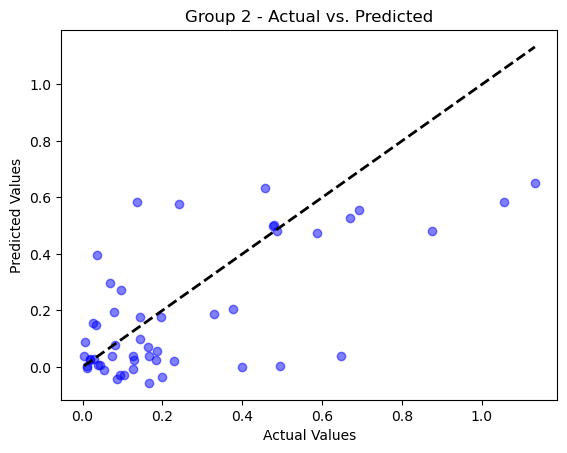

Results for group_num 2:
MSE: 0.047094150740017805
R-squared: 0.3617499419146296



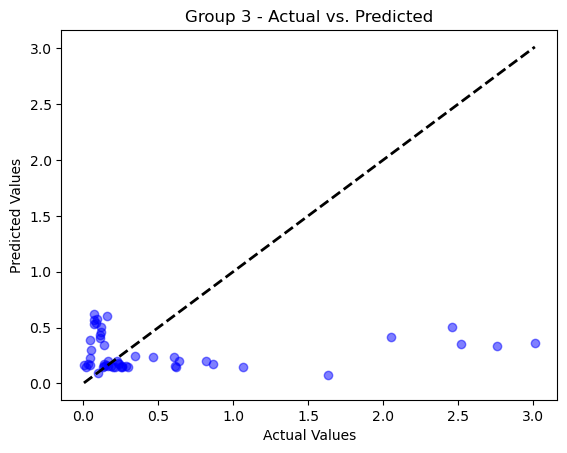

Results for group_num 3:
MSE: 0.6143071450293984
R-squared: -0.09644024283954944



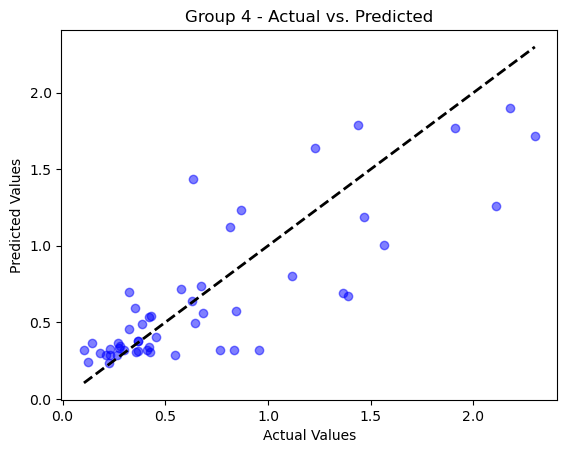

Results for group_num 4:
MSE: 0.10369636199306002
R-squared: 0.6718539570032616



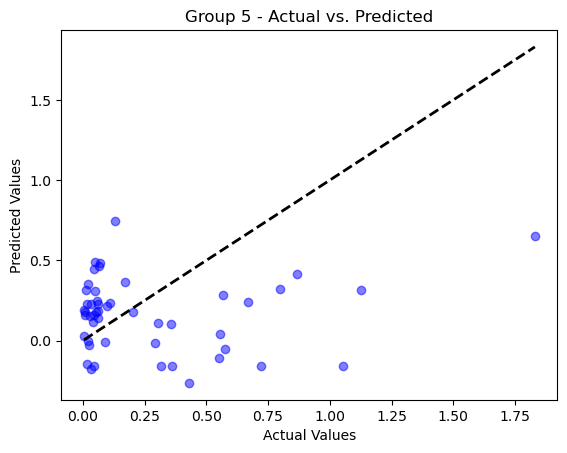

Results for group_num 5:
MSE: 0.18482234853773638
R-squared: -0.34777712898670377



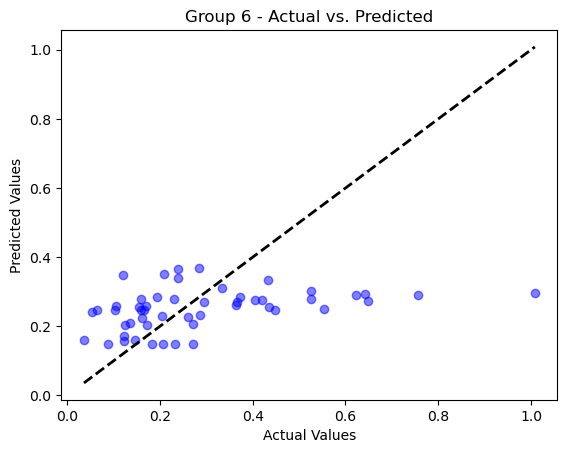

Results for group_num 6:
MSE: 0.0352857053154053
R-squared: 0.09986164888957438



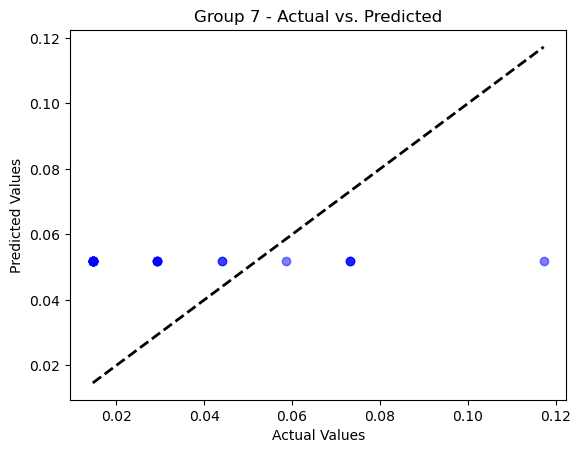

Results for group_num 7:
MSE: 0.0010711219234815004
R-squared: -0.5802263818703266



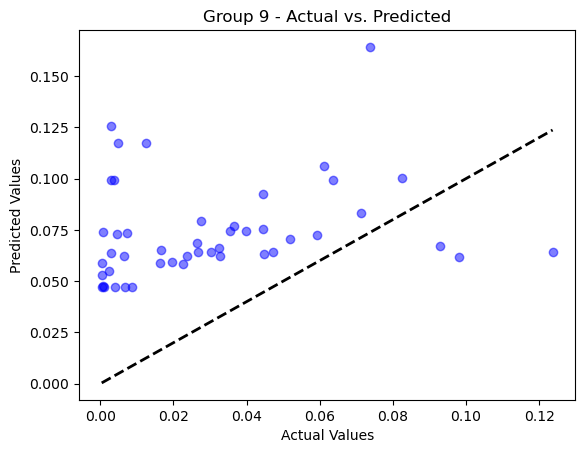

Results for group_num 9:
MSE: 0.003032825465797746
R-squared: -2.3926521303256223

Total MSE: 0.14132995128641387, Total R-squared: -0.3262329051735338


In [31]:
eval_test(regression_models_svr, merged_df_test)

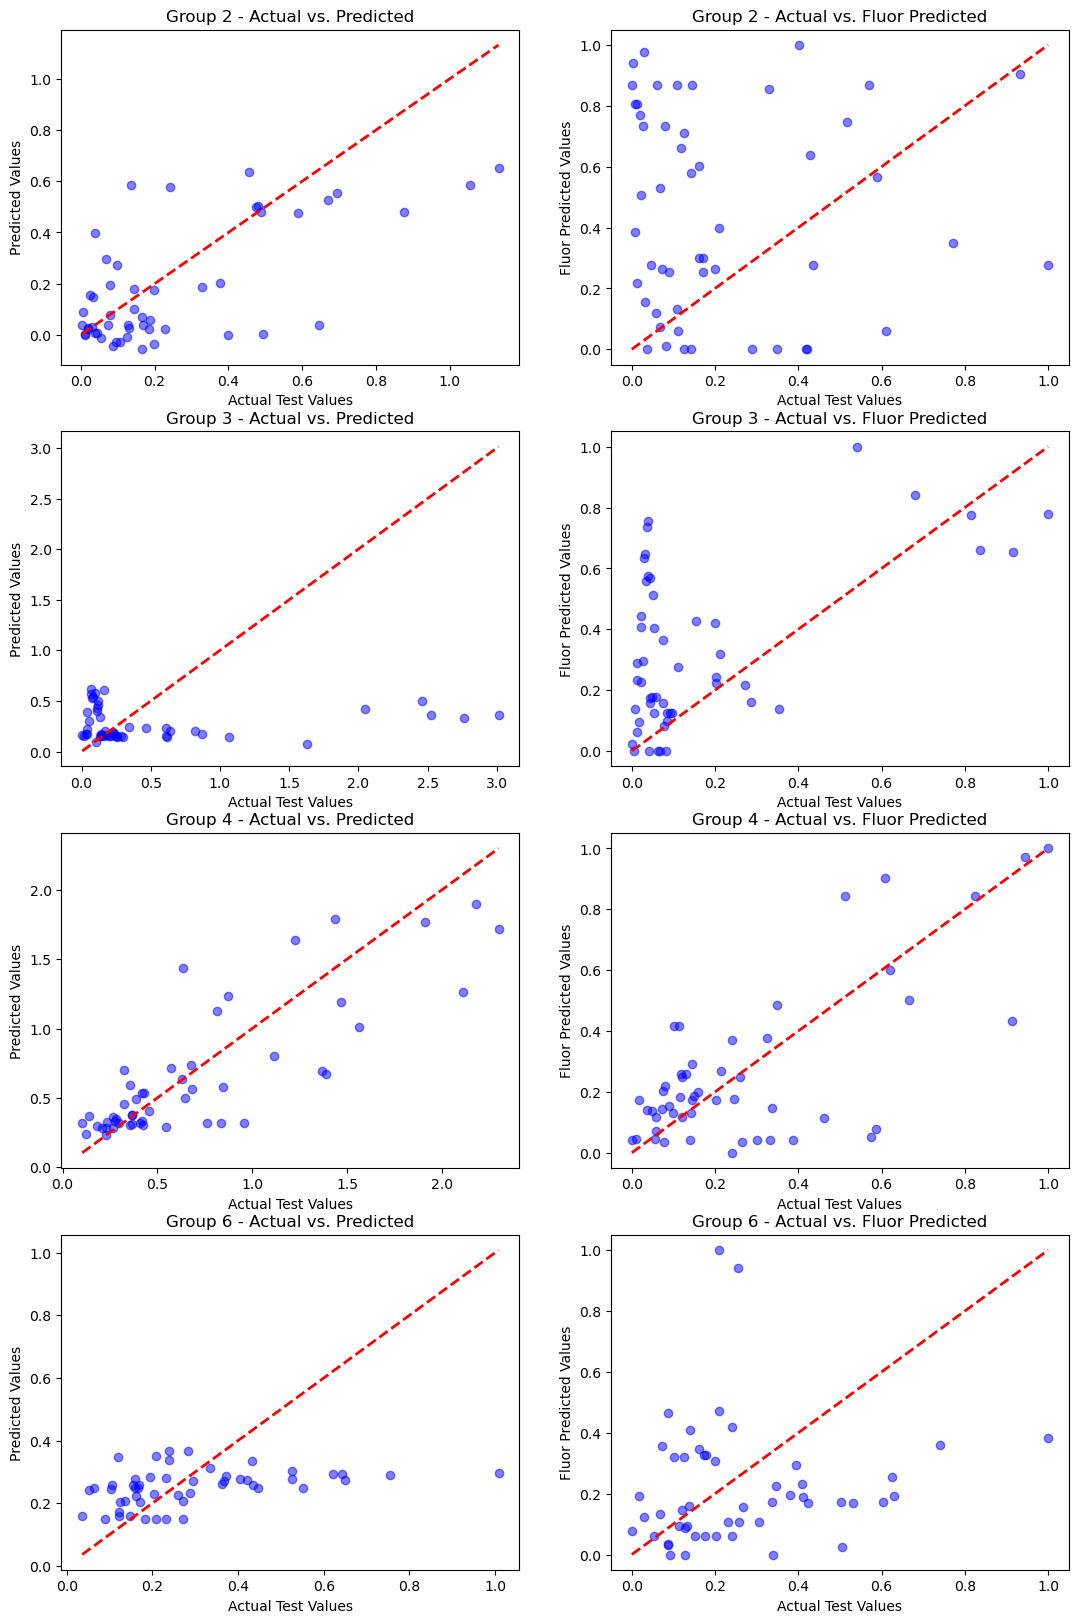

In [32]:
compare_to_fluor(regression_models_svr, merged_df_test, fluor_groups_map, fluor_test_df)

## ElasticNet Regression

In [42]:
regression_models_elf, preds_real_y_xgboost = train('bayes', merged_df, test_size=0.2)

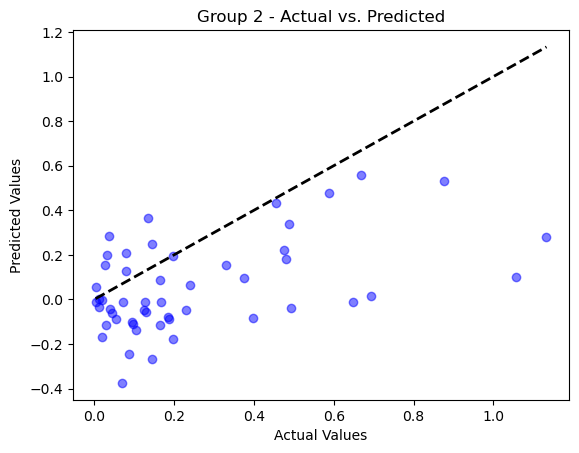

Results for group_num 2:
MSE: 0.09746104948090974
R-squared: -0.3208544907339015



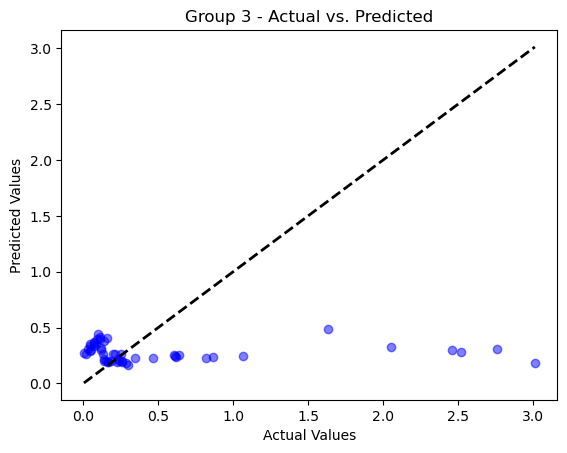

Results for group_num 3:
MSE: 0.6175761193029425
R-squared: -0.10227484036185164



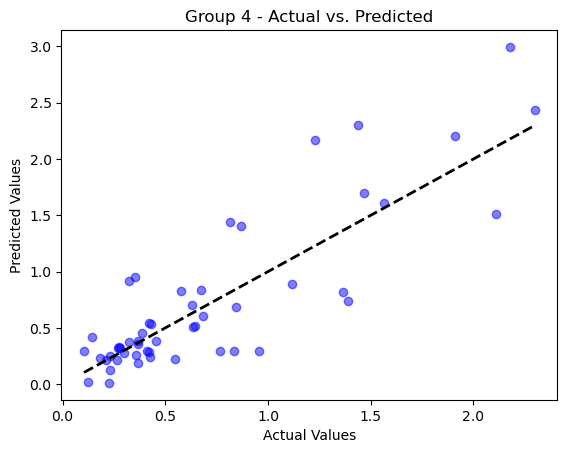

Results for group_num 4:
MSE: 0.1277708167184518
R-squared: 0.5956705991341575



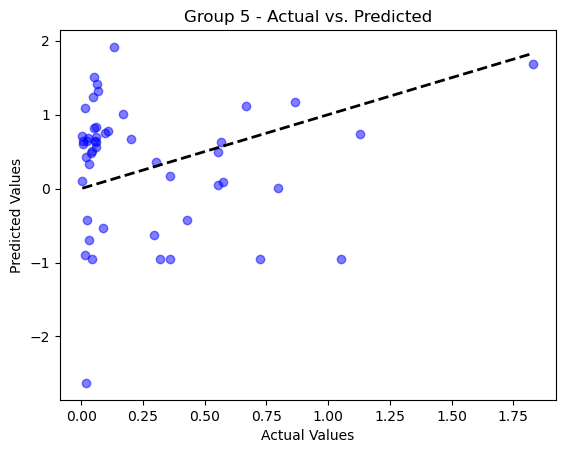

Results for group_num 5:
MSE: 0.8521097448600555
R-squared: -5.213826599409275



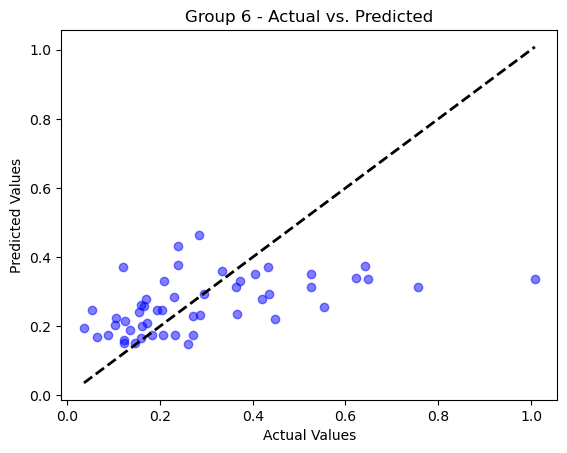

Results for group_num 6:
MSE: 0.030312582891134598
R-squared: 0.22672600313273383



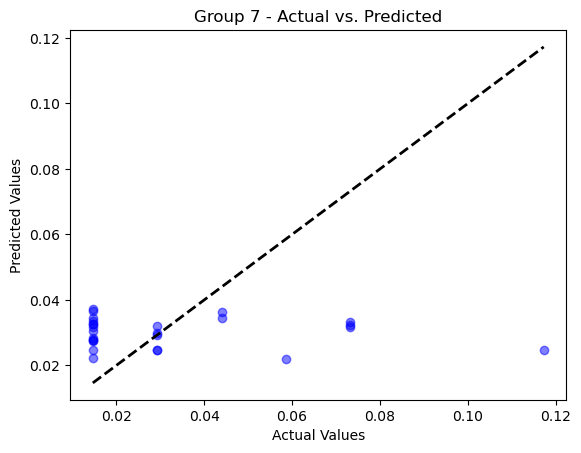

Results for group_num 7:
MSE: 0.0007290165244414569
R-squared: -0.07551822018298981



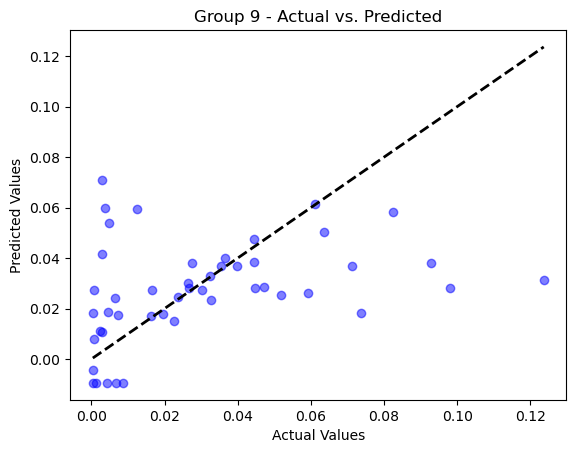

Results for group_num 9:
MSE: 0.0008737717882355563
R-squared: 0.022560397158878365

Total MSE: 0.24669044308088162, Total R-squared: -0.695359593037464


In [43]:
eval_test(regression_models_elf, merged_df_test)

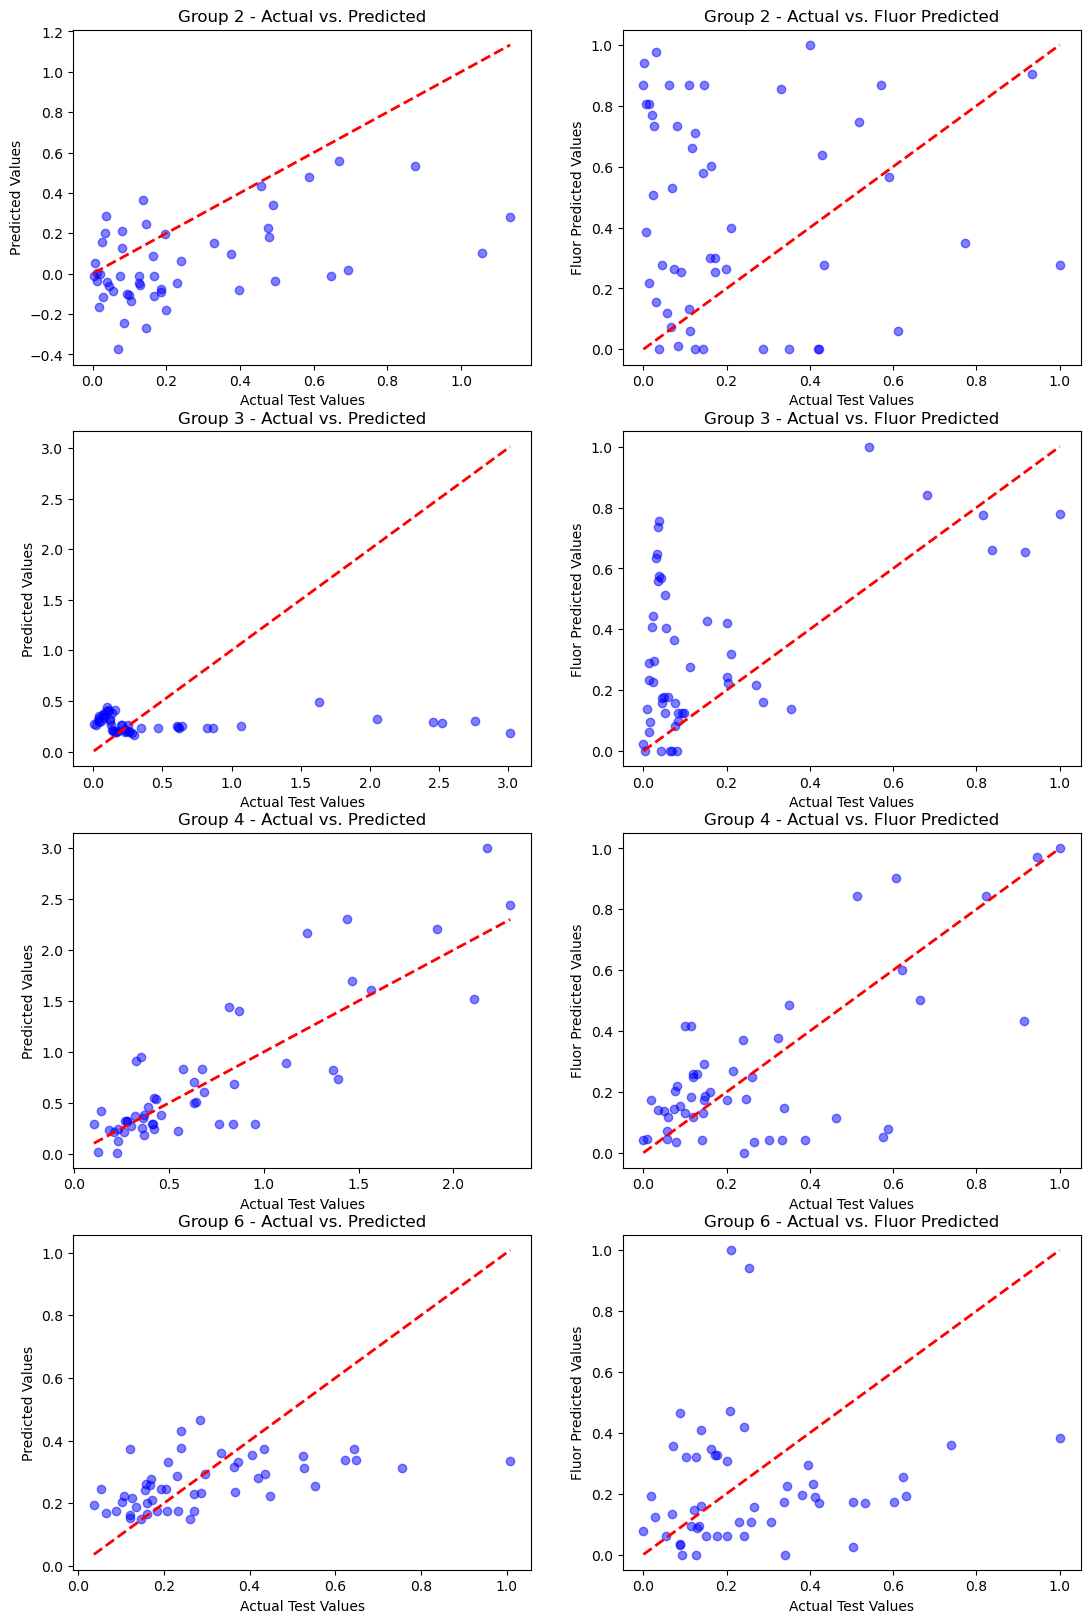

In [44]:
compare_to_fluor(regression_models_elf, merged_df_test, fluor_groups_map, fluor_test_df)